In [1]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Importar bibliotecas necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt  # Para visualización de gráficas
from torchvision.utils import make_grid  # Para visualizar imágenes
import wandb  # Para registro con Weights & Biases
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.evaluation import ModelEvaluator
from scripts.MNIST.training import Training

# Configuración inicial
output_model_dir = './models'  # Ruta relativa al directorio actual

# Crear directorios si no existen
os.makedirs(output_model_dir, exist_ok=True)

# Definir función para ejecutar experimentos
def run_experiment(target_digit, bag_size, num_epochs, learning_rate, pooling_type):
    """
    Ejecuta un experimento con los hiperparámetros dados y registra resultados en wandb.
    
    Args:
        target_digit (int): Dígito objetivo para las bolsas.
        bag_size (int): Número de instancias por bolsa.
        num_epochs (int): Número de épocas de entrenamiento.
        learning_rate (float): Tasa de aprendizaje.
        pooling_type (str): Tipo de agrupación ('attention', 'mean', 'max').
    """
    # Inicializar wandb
    wandb.init(
        project="TFG",  # Nombre del proyecto en wandb
        config={
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": pooling_type
        }
    )
    
    print(f"=== Iniciando experimento ===")
    print(f"Target Digit: {target_digit}, Bag Size: {bag_size}, Epochs: {num_epochs}, LR: {learning_rate}, Pooling: {pooling_type}")
    wandb.log({"status": "Experiment started", "target_digit": target_digit, "bag_size": bag_size, "num_epochs": num_epochs, "learning_rate": learning_rate, "pooling_type": pooling_type})
    
    # Crear datasets
    print("Creando datasets...")
    train_dataset = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_dataset = MNISTMILDataset(subset="test", bag_size=bag_size, obj_label=target_digit)
    wandb.log({"status": "Datasets created", "train_dataset_size": len(train_dataset), "test_dataset_size": len(test_dataset)})
    
    # Dividir el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)
    print("Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...")
    train_split_idx = int(len(train_dataset) * 0.8)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_split_idx, len(train_dataset) - train_split_idx])
    wandb.log({"status": "Training and validation split completed", "train_split_size": len(train_dataset), "val_split_size": len(val_dataset)})
    
    # Entrenamiento
    print("Iniciando entrenamiento...")
    trainer = Training(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type=pooling_type
    )
    trainer.train()
    wandb.log({"status": "Training completed"})
    
    # Registrar métricas de entrenamiento en wandb
    if hasattr(trainer, 'train_losses') and hasattr(trainer, 'val_losses'):
        print("Registrando métricas de entrenamiento en wandb...")
        for epoch in range(num_epochs):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": trainer.train_losses[epoch],
                "val_loss": trainer.val_losses[epoch]
            })
        wandb.log({"status": "Training metrics logged to wandb"})
    
    # Evaluación
    print("Evaluando el modelo...")
    evaluator = ModelEvaluator(
        model_path=os.path.join(output_model_dir, 'model.pth'),
        test_dataset=test_dataset,
        batch_size=1,
        pooling_type=pooling_type
    )
    
    results, attention_weights = evaluator.evaluate()
    wandb.log({"status": "Model evaluation completed", **results})
    
    # Mostrar gráficas de entrenamiento
    if hasattr(trainer, 'train_losses') and hasattr(trainer, 'val_losses'):
        print("Generando gráfica de pérdidas durante el entrenamiento...")
        plt.figure(figsize=(10, 5))
        plt.plot(trainer.train_losses, label='Train Loss')
        plt.plot(trainer.val_losses, label='Validation Loss')
        plt.title('Loss durante el entrenamiento')
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        wandb.log({"status": "Training loss plot generated"})
    
    # Visualizar heatmaps de atención (si están disponibles)
    if attention_weights is not None:
        print("Mostrando heatmaps de atención mejorados...")
        
        num_bags = min(5, len(attention_weights))  # Mostrar máximo 5 bolsas
        
        # Obtener rangos para normalización si es necesario
        att_min, att_max = np.min(attention_weights), np.max(attention_weights)

        for i, weights in enumerate(attention_weights[:num_bags]):
            plt.figure(figsize=(6, 6))
            plt.imshow(weights, cmap='inferno', aspect='auto', vmin=att_min, vmax=att_max)
            plt.colorbar(label="Intensidad de atención")
            plt.title(f"Heatmap de atención para la bolsa {i+1}")
            plt.xlabel("Elementos en la bolsa")
            plt.ylabel("Características")
            plt.show()
            wandb.log({"status": f"Attention heatmap for bag {i+1} generated"})
        
        # Gráfica de la evolución de la atención
        print("Generando gráfica de evolución de la atención...")
        mean_attention = [np.mean(weights) for weights in attention_weights]
        plt.figure(figsize=(10, 5))
        plt.plot(mean_attention, marker='o', linestyle='-', color='blue', alpha=0.7)
        plt.title("Evolución de la Intensidad de Atención por Bolsa")
        plt.xlabel("Bolsa")
        plt.ylabel("Media de Atención")
        plt.grid(True)
        plt.show()
        wandb.log({"status": "Attention evolution plot generated"})

        # Histograma de distribución de pesos de atención
        print("Generando histograma de distribución de pesos de atención...")
        all_weights = np.concatenate([weights.flatten() for weights in attention_weights])
        plt.figure(figsize=(8, 5))
        plt.hist(all_weights, bins=30, color='purple', alpha=0.75)
        plt.title("Distribución de Pesos de Atención")
        plt.xlabel("Valor de Atención")
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.show()
        wandb.log({"status": "Attention distribution histogram generated"})
    
    # Guardar el modelo como artefacto en wandb
    print("Guardando el modelo como artefacto en wandb...")
    artifact = wandb.Artifact('trained_model', type='model')
    artifact.add_file(os.path.join(output_model_dir, 'model.pth'))
    wandb.log_artifact(artifact)
    wandb.log({"status": "Model saved as artifact in wandb"})
    
    print(f"=== Resultados del experimento ===")
    print(results)
    print(f"=== Fin del experimento ===\n")
    
    # Finalizar wandb
    wandb.log({"status": "Experiment finished"})
    wandb.finish()

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


['/home/javitrucas/miniconda3/envs/tfg/lib/python311.zip', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/lib-dynload', '', '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages', '/home/javitrucas/TFG', '/home/javitrucas/TFG/scripts']


=== Iniciando experimento ===
Target Digit: 3, Bag Size: 10, Epochs: 5, LR: 0.001, Pooling: attention
Creando datasets...
Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...
Iniciando entrenamiento...
Epoch 1/5
Entrenamiento - Loss: 1500.7691, Accuracy: 0.8646
Validación - Loss: 109.5609, Accuracy: 0.9658
Epoch 2/5
Entrenamiento - Loss: 458.8774, Accuracy: 0.9665
Validación - Loss: 64.3946, Accuracy: 0.9775
Epoch 3/5
Entrenamiento - Loss: 282.0062, Accuracy: 0.9806
Validación - Loss: 70.8394, Accuracy: 0.9817
Epoch 4/5
Entrenamiento - Loss: 216.2051, Accuracy: 0.9858
Validación - Loss: 48.6804, Accuracy: 0.9858
Epoch 5/5
Entrenamiento - Loss: 160.9960, Accuracy: 0.9879
Validación - Loss: 36.8141, Accuracy: 0.9875
Registrando métricas de entrenamiento en wandb...
Evaluando el modelo...
Generando gráfica de pérdidas durante el entrenamiento...


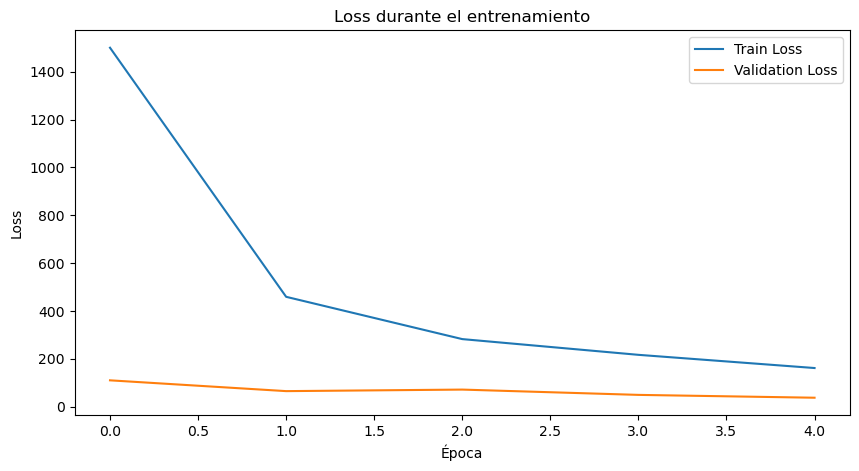

Mostrando heatmaps de atención mejorados...


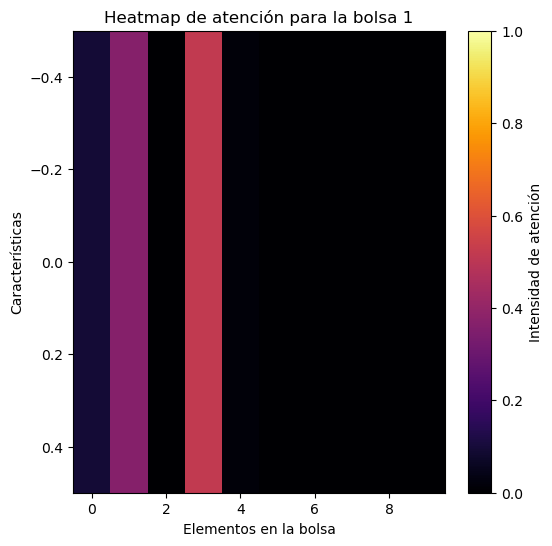

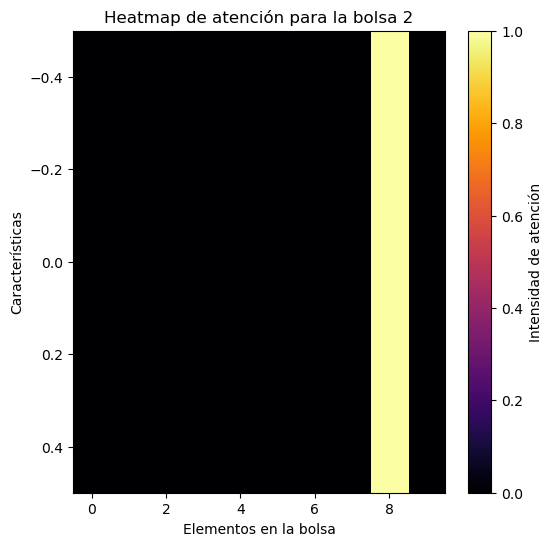

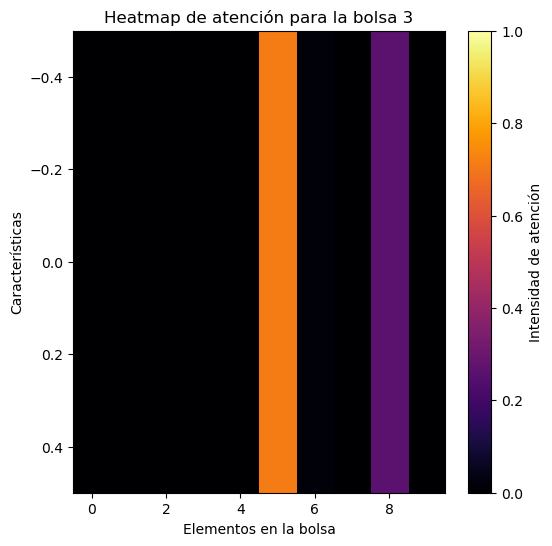

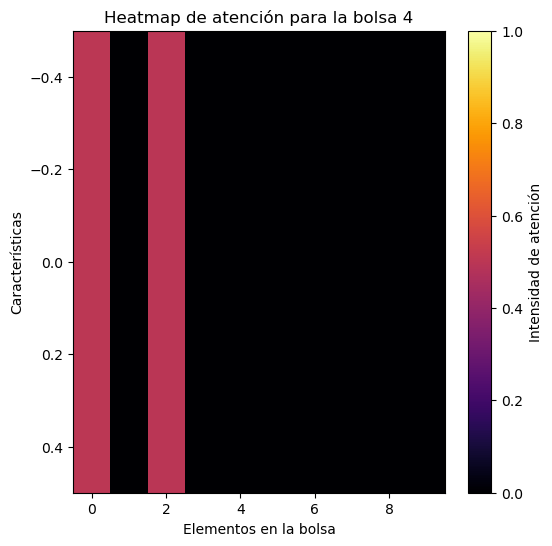

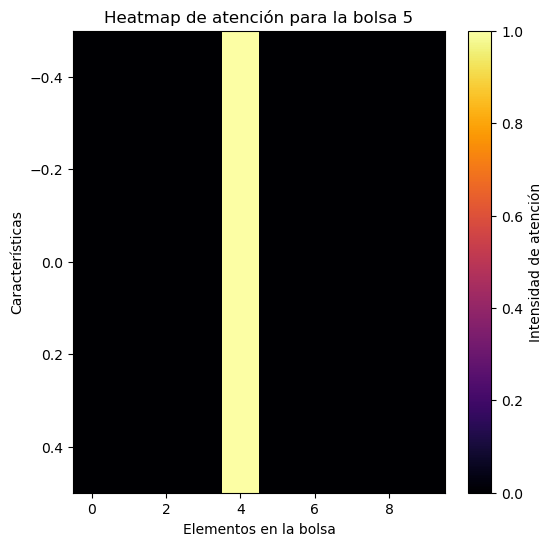

Generando gráfica de evolución de la atención...


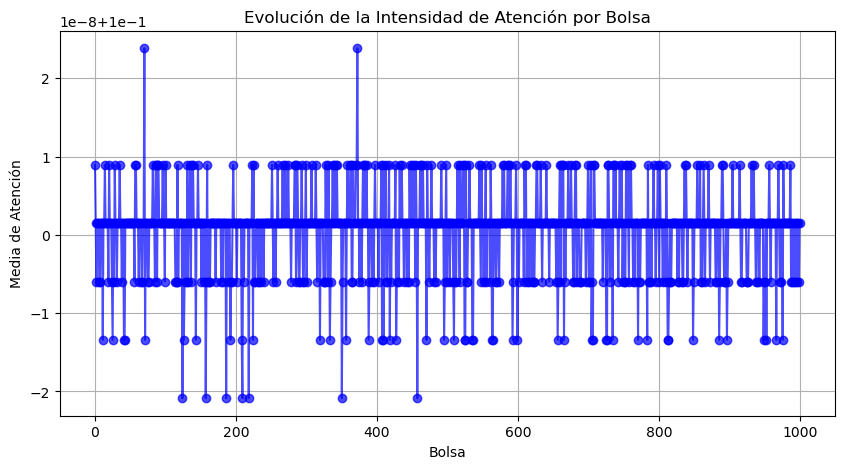

Generando histograma de distribución de pesos de atención...


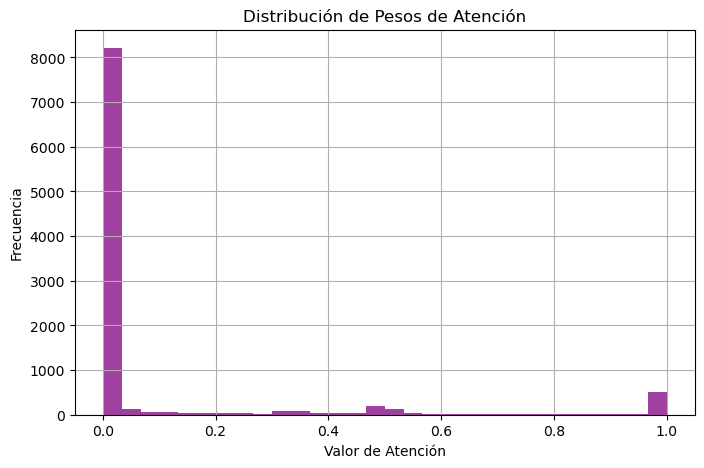

Guardando el modelo como artefacto en wandb...
=== Resultados del experimento ===
{'accuracy': 0.984, 'f1_score': 0.9884393063583815, 'auc': 0.9987451350395093, 'test_loss': 0.041441350724151164}
=== Fin del experimento ===



accuracy,▁
auc,▁
bag_size,▁
epoch,▁▃▅▆█
f1_score,▁
learning_rate,▁
num_epochs,▁
target_digit,▁
test_dataset_size,▁
test_loss,▁
train_dataset_size,▁


In [5]:
# Experimento con pooling_type="attention"
params_attention = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "attention"
}
run_experiment(**params_attention)

=== Iniciando experimento ===
Target Digit: 3, Bag Size: 10, Epochs: 5, LR: 0.001, Pooling: mean
Creando datasets...


Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...
Iniciando entrenamiento...
Epoch 1/5
Entrenamiento - Loss: 2127.1849, Accuracy: 0.7773
Validación - Loss: 281.4814, Accuracy: 0.9067
Epoch 2/5
Entrenamiento - Loss: 575.0916, Accuracy: 0.9581
Validación - Loss: 176.6069, Accuracy: 0.9533
Epoch 3/5
Entrenamiento - Loss: 402.8737, Accuracy: 0.9717
Validación - Loss: 108.0654, Accuracy: 0.9675
Epoch 4/5
Entrenamiento - Loss: 299.9071, Accuracy: 0.9806
Validación - Loss: 119.0182, Accuracy: 0.9650
Epoch 5/5
Entrenamiento - Loss: 226.0975, Accuracy: 0.9848
Validación - Loss: 90.2573, Accuracy: 0.9742
Registrando métricas de entrenamiento en wandb...
Evaluando el modelo...
Generando gráfica de pérdidas durante el entrenamiento...


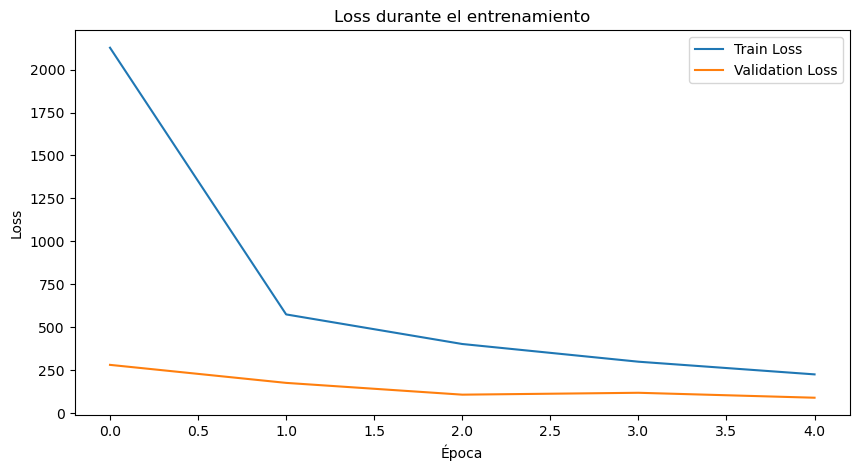

Mostrando heatmaps de atención mejorados...


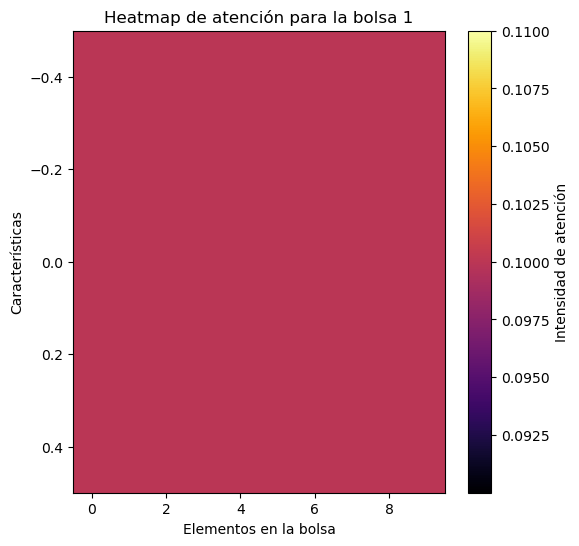

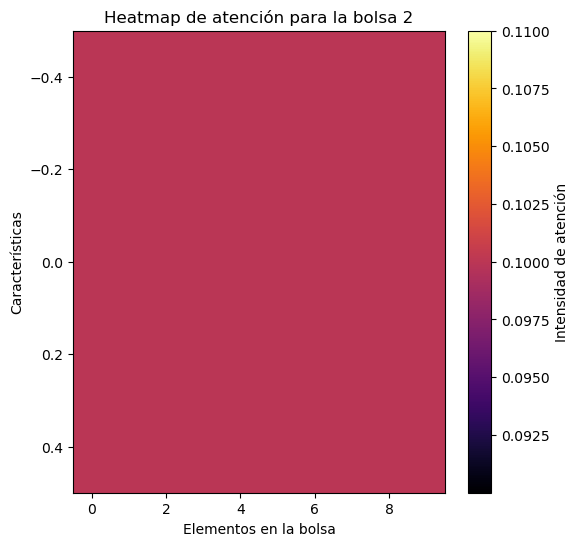

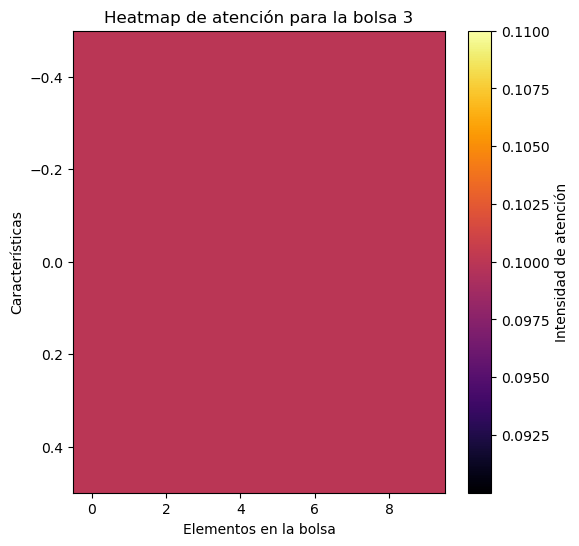

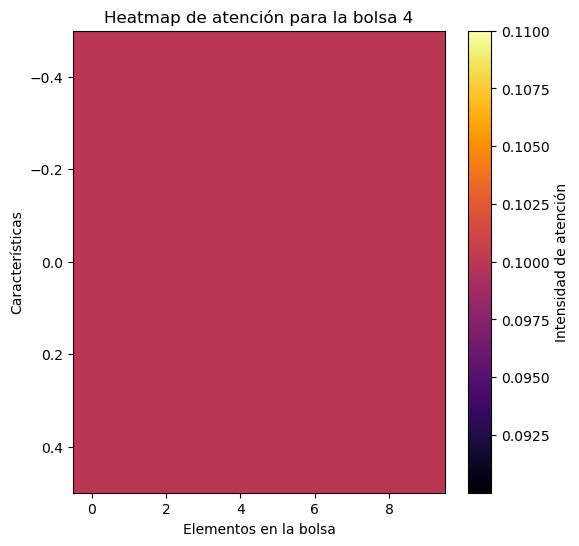

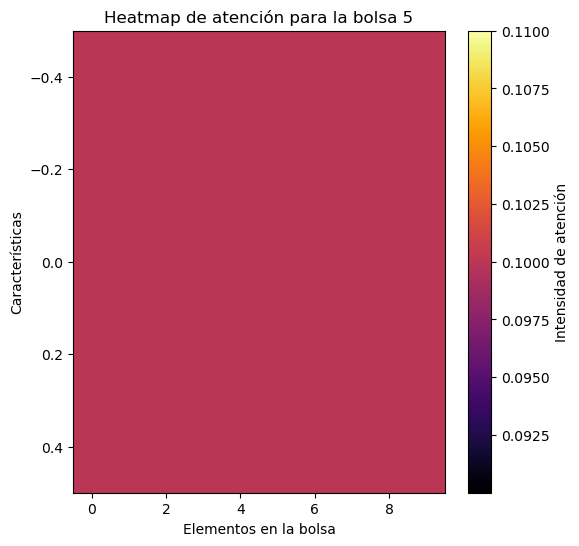

Generando gráfica de evolución de la atención...


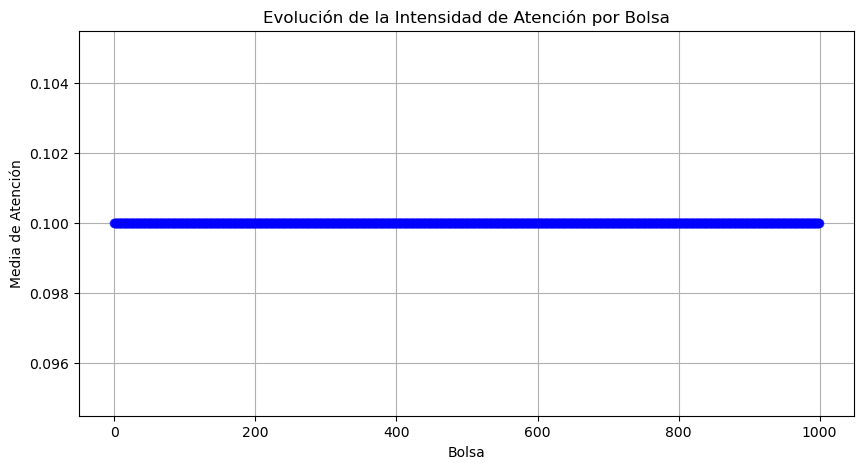

Generando histograma de distribución de pesos de atención...


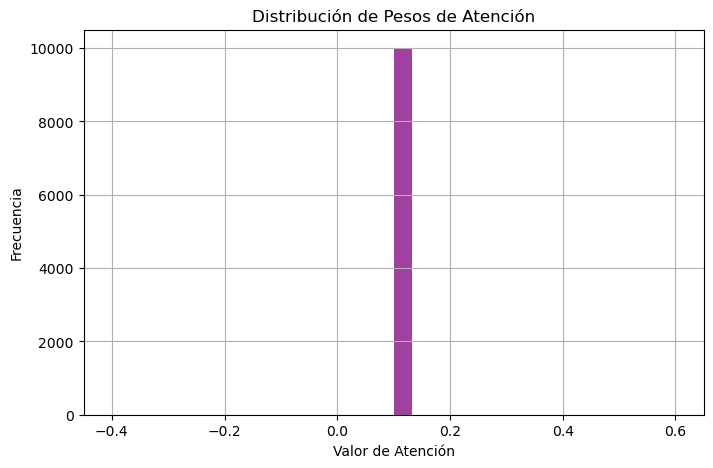

Guardando el modelo como artefacto en wandb...
=== Resultados del experimento ===
{'accuracy': 0.976, 'f1_score': 0.9828815977175464, 'auc': 0.9984762354051185, 'test_loss': 0.061352733401412875}
=== Fin del experimento ===



accuracy,▁
auc,▁
bag_size,▁
epoch,▁▃▅▆█
f1_score,▁
learning_rate,▁
num_epochs,▁
target_digit,▁
test_dataset_size,▁
test_loss,▁
train_dataset_size,▁


In [6]:
# Experimento con pooling_type="mean"
params_mean = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "mean"
}
run_experiment(**params_mean)

=== Iniciando experimento ===
Target Digit: 3, Bag Size: 10, Epochs: 5, LR: 0.001, Pooling: max
Creando datasets...
Dividiendo el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)...
Iniciando entrenamiento...
Epoch 1/5
Entrenamiento - Loss: 1164.7060, Accuracy: 0.8919
Validación - Loss: 108.5028, Accuracy: 0.9717
Epoch 2/5
Entrenamiento - Loss: 434.0930, Accuracy: 0.9696
Validación - Loss: 113.3776, Accuracy: 0.9633
Epoch 3/5
Entrenamiento - Loss: 297.1199, Accuracy: 0.9785
Validación - Loss: 70.5438, Accuracy: 0.9825
Epoch 4/5
Entrenamiento - Loss: 195.3881, Accuracy: 0.9856
Validación - Loss: 78.0493, Accuracy: 0.9825
Epoch 5/5
Entrenamiento - Loss: 166.9605, Accuracy: 0.9883
Validación - Loss: 74.1318, Accuracy: 0.9775
Registrando métricas de entrenamiento en wandb...
Evaluando el modelo...
Generando gráfica de pérdidas durante el entrenamiento...


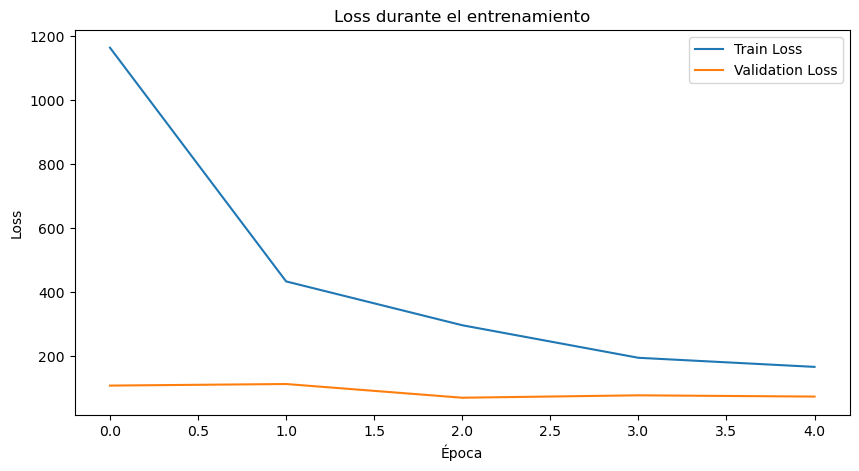

Mostrando heatmaps de atención mejorados...


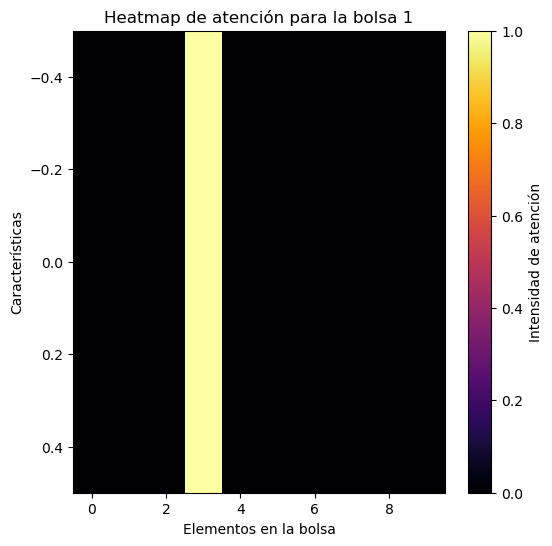

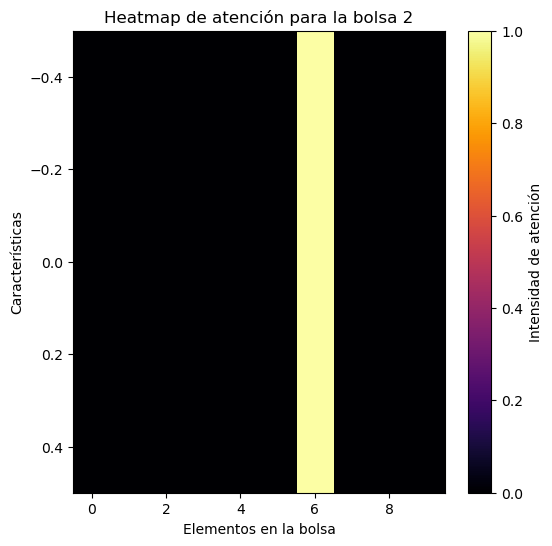

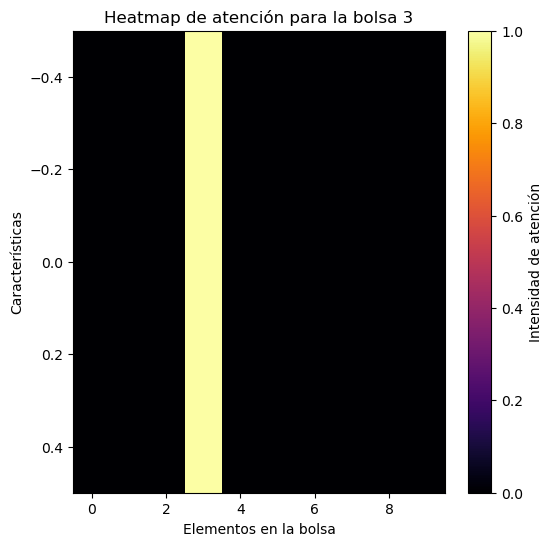

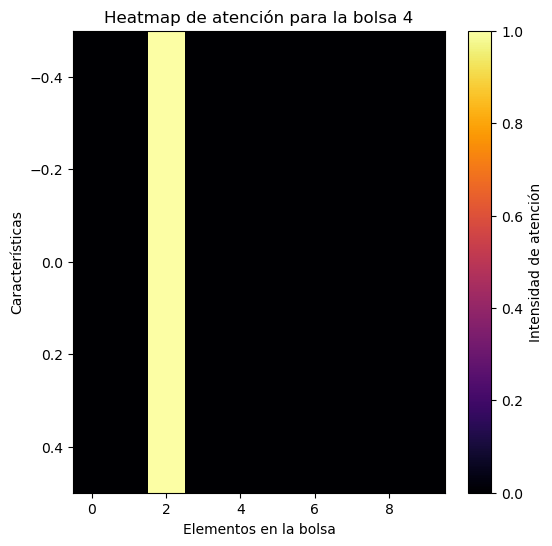

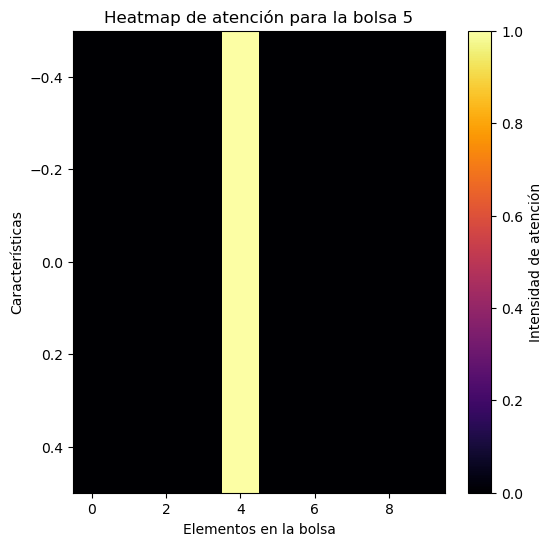

Generando gráfica de evolución de la atención...


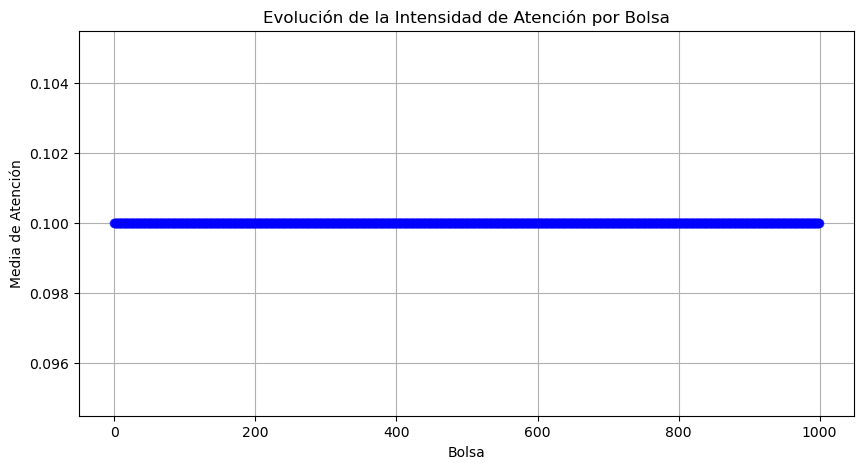

Generando histograma de distribución de pesos de atención...


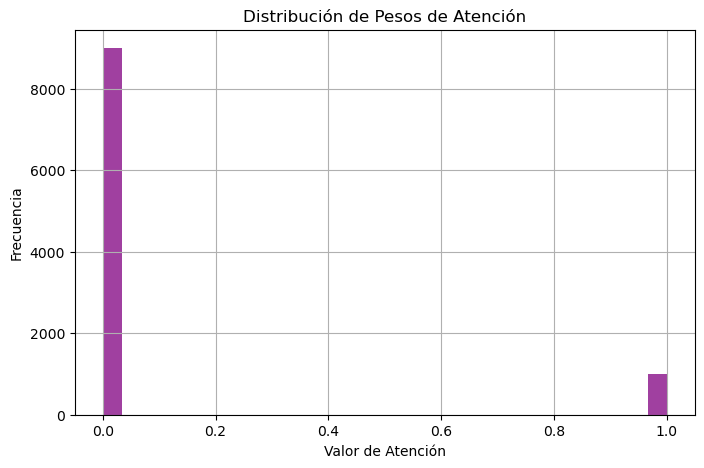

Guardando el modelo como artefacto en wandb...
=== Resultados del experimento ===
{'accuracy': 0.978, 'f1_score': 0.9842632331902719, 'auc': 0.9981554428588277, 'test_loss': 0.05781892296851564}
=== Fin del experimento ===



accuracy,▁
auc,▁
bag_size,▁
epoch,▁▃▅▆█
f1_score,▁
learning_rate,▁
num_epochs,▁
target_digit,▁
test_dataset_size,▁
test_loss,▁
train_dataset_size,▁


In [7]:
# Experimento con pooling_type="max"
params_max = {
    "target_digit": 3,
    "bag_size": 10,
    "num_epochs": 5,
    "learning_rate": 1e-3,
    "pooling_type": "max"
}
run_experiment(**params_max)

In [ ]:
import os
import torch
import random
import numpy as np
import csv
import pandas as pd
import wandb
from tqdm import tqdm
from box import Box
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.training import Training
from scripts.MNIST.evaluation import ModelEvaluator
import itertools

def run_experiment_mnist(target_digit, bag_size, num_epochs, learning_rate, pooling_type, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    wandb.init(
        project="TFG",
        config={
            "target_digit": target_digit,
            "bag_size": bag_size,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "pooling_type": pooling_type,
            "seed": seed
        }
    )

    # Datasets
    train_ds = MNISTMILDataset(subset="train", bag_size=bag_size, obj_label=target_digit)
    test_ds  = MNISTMILDataset(subset="test",  bag_size=bag_size, obj_label=target_digit)
    split_idx = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [split_idx, len(train_ds) - split_idx])

    # Entrenamiento
    trainer = Training(
        train_dataset=train_ds,
        val_dataset=val_ds,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir="./models",
        pooling_type=pooling_type
    )
    trainer.train()

    # Guardar y evaluar
    model_path = os.path.join("./models", "model.pth")
    torch.save(trainer.model.state_dict(), model_path)
    evaluator = ModelEvaluator(
        model_path=model_path,
        test_dataset=test_ds,
        batch_size=1,
        pooling_type=pooling_type
    )
    results, _ = evaluator.evaluate()
    wandb.finish()

    return {
        "test_loss":     results.get("loss"),
        "test_accuracy": results.get("accuracy"),
        "test_f1_score": results.get("f1_score"),
        "test_auc_roc":  results.get("auc_roc"),
        "test_precision":results.get("precision"),
        "test_recall":   results.get("recall")
    }

def run_all_experiments_mnist():
    # Rangos ampliados de hiperparámetros
    target_digits   = list(range(3))            # Dígitos 0-2
    bag_sizes       = [10, 15, 20]            # Múltiples tamaños de bolsa
    num_epochs_list = [5, 10]                # Varias épocas
    learning_rates  = [1e-2, 1e-3, 1e-4]         # Diferentes LR
    pooling_types   = ["attention", "mean", "max"]
    seeds           = list(range(5))            # Semillas 0-4

    combos = list(itertools.product(
        target_digits, bag_sizes, num_epochs_list, learning_rates, pooling_types
    ))

    csv_file = "mnist_experiment_runs.csv"
    header = [
        "target_digit", "bag_size", "num_epochs",
        "learning_rate", "pooling_type", "seed",
        "test_loss", "test_accuracy", "test_f1_score",
        "test_auc_roc", "test_precision", "test_recall"
    ]
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    rows = []

    for target_digit, bag_size, num_epochs, lr, pooling in tqdm(combos, desc="MNIST combos"):
        for seed in seeds:
            metrics = run_experiment_mnist(
                target_digit, bag_size, num_epochs, lr, pooling, seed
            )
            row = {
                "target_digit": target_digit,
                "bag_size": bag_size,
                "num_epochs": num_epochs,
                "learning_rate": lr,
                "pooling_type": pooling,
                "seed": seed,
                **metrics
            }
            rows.append(row)
            with open(csv_file, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([row[col] for col in header])

    df = pd.DataFrame(rows)
    display(df)

# Ejecución
run_all_experiments_mnist()


MNIST combos:   0%|          | 0/162 [00:00<?, ?it/s]wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5
Entrenamiento - Loss: 3118.5911, Accuracy: 0.6571
Validación - Loss: 775.1243, Accuracy: 0.6525
Epoch 2/5
Entrenamiento - Loss: 3090.8293, Accuracy: 0.6571
Validación - Loss: 775.2741, Accuracy: 0.6525
Epoch 3/5
Entrenamiento - Loss: 3092.6417, Accuracy: 0.6571
Validación - Loss: 779.4961, Accuracy: 0.6525
Epoch 4/5
Entrenamiento - Loss: 3092.6482, Accuracy: 0.6571
Validación - Loss: 777.7848, Accuracy: 0.6525
Epoch 5/5
Entrenamiento - Loss: 3093.2837, Accuracy: 0.6571
Validación - Loss: 776.2428, Accuracy: 0.6525


Epoch 1/5
Entrenamiento - Loss: 3111.5439, Accuracy: 0.6540
Validación - Loss: 767.3635, Accuracy: 0.6633
Epoch 2/5
Entrenamiento - Loss: 3097.0306, Accuracy: 0.6544
Validación - Loss: 773.1012, Accuracy: 0.6633
Epoch 3/5
Entrenamiento - Loss: 3101.1456, Accuracy: 0.6544
Validación - Loss: 769.4693, Accuracy: 0.6633
Epoch 4/5
Entrenamiento - Loss: 3100.7800, Accuracy: 0.6544
Validación - Loss: 766.7796, Accuracy: 0.6633
Epoch 5/5
Entrenamiento - Loss: 3098.5777, Accuracy: 0.6544
Validación - Loss: 768.0885, Accuracy: 0.6633


Epoch 1/5
Entrenamiento - Loss: 166700.8621, Accuracy: 0.6525
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 2/5
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 3/5
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 4/5
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 5/5
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700


Epoch 1/5
Entrenamiento - Loss: 3123.9167, Accuracy: 0.6533
Validación - Loss: 764.7751, Accuracy: 0.6683
Epoch 2/5
Entrenamiento - Loss: 3105.1727, Accuracy: 0.6531
Validación - Loss: 767.4390, Accuracy: 0.6683
Epoch 3/5
Entrenamiento - Loss: 3103.0690, Accuracy: 0.6531
Validación - Loss: 762.8739, Accuracy: 0.6683
Epoch 4/5
Entrenamiento - Loss: 3103.4018, Accuracy: 0.6531
Validación - Loss: 765.4800, Accuracy: 0.6683
Epoch 5/5
Entrenamiento - Loss: 3103.7357, Accuracy: 0.6531
Validación - Loss: 765.9284, Accuracy: 0.6683


Epoch 1/5
Entrenamiento - Loss: 3102.0258, Accuracy: 0.6548
Validación - Loss: 775.0989, Accuracy: 0.6550
Epoch 2/5
Entrenamiento - Loss: 3093.8568, Accuracy: 0.6565
Validación - Loss: 773.7798, Accuracy: 0.6550
Epoch 3/5
Entrenamiento - Loss: 3095.4622, Accuracy: 0.6565
Validación - Loss: 773.8831, Accuracy: 0.6550
Epoch 4/5
Entrenamiento - Loss: 3092.3876, Accuracy: 0.6565
Validación - Loss: 773.7673, Accuracy: 0.6550
Epoch 5/5
Entrenamiento - Loss: 3092.0097, Accuracy: 0.6565
Validación - Loss: 774.2079, Accuracy: 0.6550


MNIST combos:   1%|          | 1/162 [10:39<28:35:25, 639.29s/it]

Epoch 1/5
Entrenamiento - Loss: 164600.6872, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 2/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 3/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 4/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 5/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525


Epoch 1/5
Entrenamiento - Loss: 3122.8183, Accuracy: 0.6542
Validación - Loss: 767.4073, Accuracy: 0.6633
Epoch 2/5
Entrenamiento - Loss: 3102.2119, Accuracy: 0.6544
Validación - Loss: 771.3534, Accuracy: 0.6633
Epoch 3/5
Entrenamiento - Loss: 3099.3023, Accuracy: 0.6544
Validación - Loss: 766.8944, Accuracy: 0.6633
Epoch 4/5
Entrenamiento - Loss: 3102.4868, Accuracy: 0.6544
Validación - Loss: 768.1424, Accuracy: 0.6633
Epoch 5/5
Entrenamiento - Loss: 3098.7671, Accuracy: 0.6544
Validación - Loss: 767.7929, Accuracy: 0.6633


Epoch 1/5
Entrenamiento - Loss: 3114.8954, Accuracy: 0.6508
Validación - Loss: 761.4452, Accuracy: 0.6700
Epoch 2/5
Entrenamiento - Loss: 3107.1799, Accuracy: 0.6527
Validación - Loss: 761.2550, Accuracy: 0.6700
Epoch 3/5
Entrenamiento - Loss: 3106.1385, Accuracy: 0.6527
Validación - Loss: 761.0347, Accuracy: 0.6700
Epoch 4/5
Entrenamiento - Loss: 3107.3516, Accuracy: 0.6527
Validación - Loss: 763.1502, Accuracy: 0.6700
Epoch 5/5
Entrenamiento - Loss: 3104.7951, Accuracy: 0.6527
Validación - Loss: 762.4625, Accuracy: 0.6700


Epoch 1/5
Entrenamiento - Loss: 166500.7246, Accuracy: 0.6529
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 2/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 3/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 4/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 5/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683


Epoch 1/5
Entrenamiento - Loss: 3094.3042, Accuracy: 0.6565
Validación - Loss: 774.7537, Accuracy: 0.6550
Epoch 2/5
Entrenamiento - Loss: 3092.4439, Accuracy: 0.6565
Validación - Loss: 774.3780, Accuracy: 0.6550
Epoch 3/5
Entrenamiento - Loss: 3092.5354, Accuracy: 0.6565
Validación - Loss: 773.5813, Accuracy: 0.6550
Epoch 4/5
Entrenamiento - Loss: 3092.9666, Accuracy: 0.6565
Validación - Loss: 774.3870, Accuracy: 0.6550
Epoch 5/5
Entrenamiento - Loss: 3095.0776, Accuracy: 0.6565
Validación - Loss: 776.6867, Accuracy: 0.6550


MNIST combos:   1%|          | 2/162 [21:28<28:40:08, 645.05s/it]

Epoch 1/5
Entrenamiento - Loss: 164600.6841, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 2/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 3/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 4/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 5/5
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525


Epoch 1/5
Entrenamiento - Loss: 142647.6984, Accuracy: 0.6552
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 2/5
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 3/5
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 4/5
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 5/5
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633


Epoch 1/5
Entrenamiento - Loss: 3115.0398, Accuracy: 0.6510
Validación - Loss: 761.4896, Accuracy: 0.6700
Epoch 2/5
Entrenamiento - Loss: 3107.2061, Accuracy: 0.6527
Validación - Loss: 761.2550, Accuracy: 0.6700
Epoch 3/5
Entrenamiento - Loss: 3106.1385, Accuracy: 0.6527
Validación - Loss: 761.0347, Accuracy: 0.6700
Epoch 4/5
Entrenamiento - Loss: 3107.3516, Accuracy: 0.6527
Validación - Loss: 763.1502, Accuracy: 0.6700
Epoch 5/5
Entrenamiento - Loss: 3104.7951, Accuracy: 0.6527
Validación - Loss: 762.4625, Accuracy: 0.6700


Epoch 1/5
Entrenamiento - Loss: 166500.7117, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 2/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 3/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 4/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 5/5
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683


Epoch 1/5
Entrenamiento - Loss: 3099.0129, Accuracy: 0.6560
Validación - Loss: 774.7102, Accuracy: 0.6550
Epoch 2/5
Entrenamiento - Loss: 3092.4422, Accuracy: 0.6565
Validación - Loss: 774.3780, Accuracy: 0.6550
Epoch 3/5
Entrenamiento - Loss: 3092.5354, Accuracy: 0.6565
Validación - Loss: 773.5813, Accuracy: 0.6550
Epoch 4/5
Entrenamiento - Loss: 3092.9666, Accuracy: 0.6565
Validación - Loss: 774.3870, Accuracy: 0.6550
Epoch 5/5
Entrenamiento - Loss: 3095.0776, Accuracy: 0.6565
Validación - Loss: 776.6867, Accuracy: 0.6550


MNIST combos:   2%|▏         | 3/162 [36:19<33:27:17, 757.47s/it]

Epoch 1/5
Entrenamiento - Loss: 734.6876, Accuracy: 0.9435
Validación - Loss: 51.5833, Accuracy: 0.9875
Epoch 2/5
Entrenamiento - Loss: 253.9345, Accuracy: 0.9835
Validación - Loss: 40.9194, Accuracy: 0.9867
Epoch 3/5
Entrenamiento - Loss: 174.6886, Accuracy: 0.9879
Validación - Loss: 28.7716, Accuracy: 0.9908
Epoch 4/5
Entrenamiento - Loss: 138.6091, Accuracy: 0.9900
Validación - Loss: 31.9749, Accuracy: 0.9892
Epoch 5/5
Entrenamiento - Loss: 105.6792, Accuracy: 0.9921
Validación - Loss: 45.0828, Accuracy: 0.9867


Epoch 1/5
Entrenamiento - Loss: 904.7144, Accuracy: 0.9090
Validación - Loss: 92.4254, Accuracy: 0.9742
Epoch 2/5
Entrenamiento - Loss: 309.0929, Accuracy: 0.9794
Validación - Loss: 31.7195, Accuracy: 0.9908
Epoch 3/5
Entrenamiento - Loss: 200.0137, Accuracy: 0.9888
Validación - Loss: 30.0415, Accuracy: 0.9900
Epoch 4/5
Entrenamiento - Loss: 167.0436, Accuracy: 0.9888
Validación - Loss: 32.0170, Accuracy: 0.9925
Epoch 5/5
Entrenamiento - Loss: 145.1161, Accuracy: 0.9917
Validación - Loss: 34.6770, Accuracy: 0.9917


Epoch 1/5
Entrenamiento - Loss: 719.6152, Accuracy: 0.9365
Validación - Loss: 63.9649, Accuracy: 0.9792
Epoch 2/5
Entrenamiento - Loss: 248.3836, Accuracy: 0.9846
Validación - Loss: 34.9603, Accuracy: 0.9875
Epoch 3/5
Entrenamiento - Loss: 140.1578, Accuracy: 0.9906
Validación - Loss: 119.4421, Accuracy: 0.9675
Epoch 4/5
Entrenamiento - Loss: 109.6010, Accuracy: 0.9927
Validación - Loss: 28.6992, Accuracy: 0.9933
Epoch 5/5
Entrenamiento - Loss: 68.6259, Accuracy: 0.9954
Validación - Loss: 39.7915, Accuracy: 0.9933


Epoch 1/5
Entrenamiento - Loss: 778.5727, Accuracy: 0.9335
Validación - Loss: 47.0733, Accuracy: 0.9867
Epoch 2/5
Entrenamiento - Loss: 246.6490, Accuracy: 0.9852
Validación - Loss: 40.9826, Accuracy: 0.9900
Epoch 3/5
Entrenamiento - Loss: 173.4360, Accuracy: 0.9883
Validación - Loss: 24.7568, Accuracy: 0.9917
Epoch 4/5
Entrenamiento - Loss: 117.9358, Accuracy: 0.9912
Validación - Loss: 38.7553, Accuracy: 0.9900
Epoch 5/5
Entrenamiento - Loss: 85.5068, Accuracy: 0.9948
Validación - Loss: 41.3613, Accuracy: 0.9892


Epoch 1/5
Entrenamiento - Loss: 770.0128, Accuracy: 0.9277
Validación - Loss: 57.2410, Accuracy: 0.9867
Epoch 2/5
Entrenamiento - Loss: 243.9386, Accuracy: 0.9856
Validación - Loss: 38.7857, Accuracy: 0.9892
Epoch 3/5
Entrenamiento - Loss: 142.5305, Accuracy: 0.9900
Validación - Loss: 40.8801, Accuracy: 0.9858
Epoch 4/5
Entrenamiento - Loss: 113.5404, Accuracy: 0.9919
Validación - Loss: 25.9282, Accuracy: 0.9933
Epoch 5/5
Entrenamiento - Loss: 73.1161, Accuracy: 0.9948
Validación - Loss: 53.3232, Accuracy: 0.9883


MNIST combos:   2%|▏         | 4/162 [49:17<33:35:58, 765.56s/it]

Epoch 1/5
Entrenamiento - Loss: 1283.4720, Accuracy: 0.8712
Validación - Loss: 215.1899, Accuracy: 0.9475
Epoch 2/5
Entrenamiento - Loss: 385.3452, Accuracy: 0.9723
Validación - Loss: 77.9620, Accuracy: 0.9775
Epoch 3/5
Entrenamiento - Loss: 272.3921, Accuracy: 0.9806
Validación - Loss: 61.9975, Accuracy: 0.9850
Epoch 4/5
Entrenamiento - Loss: 208.8531, Accuracy: 0.9873
Validación - Loss: 73.3461, Accuracy: 0.9825
Epoch 5/5
Entrenamiento - Loss: 174.5682, Accuracy: 0.9875
Validación - Loss: 58.0241, Accuracy: 0.9858


Epoch 1/5
Entrenamiento - Loss: 1674.2483, Accuracy: 0.8271
Validación - Loss: 104.7194, Accuracy: 0.9708
Epoch 2/5
Entrenamiento - Loss: 394.3744, Accuracy: 0.9717
Validación - Loss: 55.6058, Accuracy: 0.9858
Epoch 3/5
Entrenamiento - Loss: 260.0755, Accuracy: 0.9827
Validación - Loss: 43.6313, Accuracy: 0.9850
Epoch 4/5
Entrenamiento - Loss: 207.6024, Accuracy: 0.9867
Validación - Loss: 61.8989, Accuracy: 0.9833
Epoch 5/5
Entrenamiento - Loss: 144.5736, Accuracy: 0.9898
Validación - Loss: 34.5328, Accuracy: 0.9900


Epoch 1/5
Entrenamiento - Loss: 937.3680, Accuracy: 0.9131
Validación - Loss: 157.4348, Accuracy: 0.9542
Epoch 2/5
Entrenamiento - Loss: 282.8322, Accuracy: 0.9804
Validación - Loss: 71.9222, Accuracy: 0.9792
Epoch 3/5
Entrenamiento - Loss: 161.7801, Accuracy: 0.9900
Validación - Loss: 41.6289, Accuracy: 0.9867
Epoch 4/5
Entrenamiento - Loss: 131.7038, Accuracy: 0.9904
Validación - Loss: 64.0894, Accuracy: 0.9825
Epoch 5/5
Entrenamiento - Loss: 107.7735, Accuracy: 0.9921
Validación - Loss: 39.0542, Accuracy: 0.9900


Epoch 1/5
Entrenamiento - Loss: 986.9444, Accuracy: 0.9150
Validación - Loss: 92.7389, Accuracy: 0.9767
Epoch 2/5
Entrenamiento - Loss: 315.6925, Accuracy: 0.9808
Validación - Loss: 63.9142, Accuracy: 0.9800
Epoch 3/5
Entrenamiento - Loss: 184.2383, Accuracy: 0.9879
Validación - Loss: 112.0321, Accuracy: 0.9708
Epoch 4/5
Entrenamiento - Loss: 162.1576, Accuracy: 0.9885
Validación - Loss: 54.6613, Accuracy: 0.9842
Epoch 5/5
Entrenamiento - Loss: 93.7109, Accuracy: 0.9931
Validación - Loss: 32.0552, Accuracy: 0.9892


Epoch 1/5
Entrenamiento - Loss: 1055.8890, Accuracy: 0.8985
Validación - Loss: 210.8306, Accuracy: 0.9342
Epoch 2/5
Entrenamiento - Loss: 264.3590, Accuracy: 0.9812
Validación - Loss: 61.1304, Accuracy: 0.9842
Epoch 3/5
Entrenamiento - Loss: 182.5277, Accuracy: 0.9875
Validación - Loss: 43.5483, Accuracy: 0.9900
Epoch 4/5
Entrenamiento - Loss: 132.9760, Accuracy: 0.9906
Validación - Loss: 39.8594, Accuracy: 0.9908
Epoch 5/5
Entrenamiento - Loss: 105.9995, Accuracy: 0.9933
Validación - Loss: 38.4567, Accuracy: 0.9908


MNIST combos:   3%|▎         | 5/162 [58:41<30:12:38, 692.73s/it]

Epoch 1/5
Entrenamiento - Loss: 656.7259, Accuracy: 0.9448
Validación - Loss: 154.8636, Accuracy: 0.9558
Epoch 2/5
Entrenamiento - Loss: 223.3885, Accuracy: 0.9848
Validación - Loss: 39.3249, Accuracy: 0.9883
Epoch 3/5
Entrenamiento - Loss: 158.1600, Accuracy: 0.9890
Validación - Loss: 18.6734, Accuracy: 0.9950
Epoch 4/5
Entrenamiento - Loss: 89.3364, Accuracy: 0.9935
Validación - Loss: 26.3521, Accuracy: 0.9925
Epoch 5/5
Entrenamiento - Loss: 98.0581, Accuracy: 0.9929
Validación - Loss: 19.0643, Accuracy: 0.9975


Epoch 1/5
Entrenamiento - Loss: 647.9804, Accuracy: 0.9452
Validación - Loss: 57.1902, Accuracy: 0.9833
Epoch 2/5
Entrenamiento - Loss: 233.3507, Accuracy: 0.9846
Validación - Loss: 28.8717, Accuracy: 0.9917
Epoch 3/5
Entrenamiento - Loss: 145.3394, Accuracy: 0.9898
Validación - Loss: 32.3826, Accuracy: 0.9900
Epoch 4/5
Entrenamiento - Loss: 109.4658, Accuracy: 0.9929
Validación - Loss: 44.3037, Accuracy: 0.9892
Epoch 5/5
Entrenamiento - Loss: 88.1514, Accuracy: 0.9935
Validación - Loss: 23.9479, Accuracy: 0.9925


Epoch 1/5
Entrenamiento - Loss: 579.3337, Accuracy: 0.9525
Validación - Loss: 57.0208, Accuracy: 0.9817
Epoch 2/5
Entrenamiento - Loss: 199.4952, Accuracy: 0.9862
Validación - Loss: 56.3101, Accuracy: 0.9858
Epoch 3/5
Entrenamiento - Loss: 113.8642, Accuracy: 0.9915
Validación - Loss: 41.4146, Accuracy: 0.9900
Epoch 4/5
Entrenamiento - Loss: 78.7341, Accuracy: 0.9950
Validación - Loss: 104.5953, Accuracy: 0.9725
Epoch 5/5
Entrenamiento - Loss: 88.5193, Accuracy: 0.9940
Validación - Loss: 61.6030, Accuracy: 0.9833


Epoch 1/5
Entrenamiento - Loss: 615.9222, Accuracy: 0.9498
Validación - Loss: 72.0373, Accuracy: 0.9783
Epoch 2/5
Entrenamiento - Loss: 240.9955, Accuracy: 0.9825
Validación - Loss: 53.6992, Accuracy: 0.9825
Epoch 3/5
Entrenamiento - Loss: 135.7128, Accuracy: 0.9904
Validación - Loss: 39.4857, Accuracy: 0.9908
Epoch 4/5
Entrenamiento - Loss: 120.6575, Accuracy: 0.9917
Validación - Loss: 38.8147, Accuracy: 0.9883
Epoch 5/5
Entrenamiento - Loss: 83.3978, Accuracy: 0.9940
Validación - Loss: 17.6943, Accuracy: 0.9950


Epoch 1/5
Entrenamiento - Loss: 556.3267, Accuracy: 0.9523
Validación - Loss: 70.4929, Accuracy: 0.9817
Epoch 2/5
Entrenamiento - Loss: 189.6086, Accuracy: 0.9858
Validación - Loss: 28.0801, Accuracy: 0.9933
Epoch 3/5
Entrenamiento - Loss: 125.4028, Accuracy: 0.9912
Validación - Loss: 30.5063, Accuracy: 0.9933
Epoch 4/5
Entrenamiento - Loss: 82.3377, Accuracy: 0.9946
Validación - Loss: 88.1301, Accuracy: 0.9775
Epoch 5/5
Entrenamiento - Loss: 83.9081, Accuracy: 0.9944
Validación - Loss: 25.4057, Accuracy: 0.9942


MNIST combos:   4%|▎         | 6/162 [1:10:47<30:30:46, 704.14s/it]

Epoch 1/5
Entrenamiento - Loss: 1042.7539, Accuracy: 0.9065
Validación - Loss: 116.2294, Accuracy: 0.9658
Epoch 2/5
Entrenamiento - Loss: 349.3968, Accuracy: 0.9754
Validación - Loss: 79.7700, Accuracy: 0.9800
Epoch 3/5
Entrenamiento - Loss: 248.3828, Accuracy: 0.9815
Validación - Loss: 58.4719, Accuracy: 0.9850
Epoch 4/5
Entrenamiento - Loss: 213.3357, Accuracy: 0.9869
Validación - Loss: 50.8990, Accuracy: 0.9842
Epoch 5/5
Entrenamiento - Loss: 177.3350, Accuracy: 0.9879
Validación - Loss: 61.6551, Accuracy: 0.9858


Epoch 1/5
Entrenamiento - Loss: 1145.8213, Accuracy: 0.8925
Validación - Loss: 130.6155, Accuracy: 0.9592
Epoch 2/5
Entrenamiento - Loss: 429.3992, Accuracy: 0.9710
Validación - Loss: 76.6532, Accuracy: 0.9792
Epoch 3/5
Entrenamiento - Loss: 292.1982, Accuracy: 0.9810
Validación - Loss: 88.6050, Accuracy: 0.9733
Epoch 4/5
Entrenamiento - Loss: 228.9640, Accuracy: 0.9848
Validación - Loss: 52.4785, Accuracy: 0.9858
Epoch 5/5
Entrenamiento - Loss: 217.9060, Accuracy: 0.9840
Validación - Loss: 47.5406, Accuracy: 0.9833


Epoch 1/5
Entrenamiento - Loss: 1255.3972, Accuracy: 0.8808
Validación - Loss: 130.6400, Accuracy: 0.9608
Epoch 2/5
Entrenamiento - Loss: 417.2252, Accuracy: 0.9690
Validación - Loss: 89.3107, Accuracy: 0.9692
Epoch 3/5
Entrenamiento - Loss: 292.3471, Accuracy: 0.9792
Validación - Loss: 69.3917, Accuracy: 0.9792
Epoch 4/5
Entrenamiento - Loss: 231.1950, Accuracy: 0.9840
Validación - Loss: 62.8037, Accuracy: 0.9817
Epoch 5/5
Entrenamiento - Loss: 190.5346, Accuracy: 0.9875
Validación - Loss: 61.7419, Accuracy: 0.9825


Epoch 1/5
Entrenamiento - Loss: 1293.0158, Accuracy: 0.8742
Validación - Loss: 108.7941, Accuracy: 0.9667
Epoch 2/5
Entrenamiento - Loss: 417.8421, Accuracy: 0.9696
Validación - Loss: 103.5671, Accuracy: 0.9700
Epoch 3/5
Entrenamiento - Loss: 314.5876, Accuracy: 0.9773
Validación - Loss: 78.8188, Accuracy: 0.9792
Epoch 4/5
Entrenamiento - Loss: 260.3594, Accuracy: 0.9825
Validación - Loss: 57.7825, Accuracy: 0.9850
Epoch 5/5
Entrenamiento - Loss: 216.8059, Accuracy: 0.9844
Validación - Loss: 49.5704, Accuracy: 0.9892


Epoch 1/5
Entrenamiento - Loss: 1280.0179, Accuracy: 0.8729
Validación - Loss: 113.6488, Accuracy: 0.9658
Epoch 2/5
Entrenamiento - Loss: 372.4702, Accuracy: 0.9740
Validación - Loss: 66.6509, Accuracy: 0.9800
Epoch 3/5
Entrenamiento - Loss: 260.4125, Accuracy: 0.9815
Validación - Loss: 51.6720, Accuracy: 0.9850
Epoch 4/5
Entrenamiento - Loss: 222.6660, Accuracy: 0.9848
Validación - Loss: 49.3609, Accuracy: 0.9867
Epoch 5/5
Entrenamiento - Loss: 171.0081, Accuracy: 0.9888
Validación - Loss: 44.8705, Accuracy: 0.9858


MNIST combos:   4%|▍         | 7/162 [1:25:56<33:11:39, 770.96s/it]

Epoch 1/5
Entrenamiento - Loss: 2178.0817, Accuracy: 0.7760
Validación - Loss: 227.7787, Accuracy: 0.9358
Epoch 2/5
Entrenamiento - Loss: 675.2102, Accuracy: 0.9517
Validación - Loss: 138.3573, Accuracy: 0.9600
Epoch 3/5
Entrenamiento - Loss: 482.9820, Accuracy: 0.9665
Validación - Loss: 118.9474, Accuracy: 0.9675
Epoch 4/5
Entrenamiento - Loss: 382.7497, Accuracy: 0.9735
Validación - Loss: 123.8440, Accuracy: 0.9650
Epoch 5/5
Entrenamiento - Loss: 317.0787, Accuracy: 0.9781
Validación - Loss: 86.4716, Accuracy: 0.9750


Epoch 1/5
Entrenamiento - Loss: 2529.4295, Accuracy: 0.7310
Validación - Loss: 353.4712, Accuracy: 0.8908
Epoch 2/5
Entrenamiento - Loss: 896.3350, Accuracy: 0.9379
Validación - Loss: 161.2341, Accuracy: 0.9492
Epoch 3/5
Entrenamiento - Loss: 557.8588, Accuracy: 0.9606
Validación - Loss: 110.9058, Accuracy: 0.9667
Epoch 4/5
Entrenamiento - Loss: 446.1346, Accuracy: 0.9696
Validación - Loss: 115.7068, Accuracy: 0.9625
Epoch 5/5
Entrenamiento - Loss: 372.4851, Accuracy: 0.9752
Validación - Loss: 84.1591, Accuracy: 0.9700


Epoch 1/5
Entrenamiento - Loss: 2470.4545, Accuracy: 0.7494
Validación - Loss: 307.5042, Accuracy: 0.9175
Epoch 2/5
Entrenamiento - Loss: 771.0724, Accuracy: 0.9444
Validación - Loss: 172.3095, Accuracy: 0.9425
Epoch 3/5
Entrenamiento - Loss: 500.4359, Accuracy: 0.9633
Validación - Loss: 123.0465, Accuracy: 0.9592
Epoch 4/5
Entrenamiento - Loss: 397.0399, Accuracy: 0.9712
Validación - Loss: 101.6693, Accuracy: 0.9683
Epoch 5/5
Entrenamiento - Loss: 327.2712, Accuracy: 0.9775
Validación - Loss: 96.5357, Accuracy: 0.9725


Epoch 1/5
Entrenamiento - Loss: 2397.9862, Accuracy: 0.7488
Validación - Loss: 271.7260, Accuracy: 0.9242
Epoch 2/5
Entrenamiento - Loss: 776.7074, Accuracy: 0.9435
Validación - Loss: 184.6785, Accuracy: 0.9408
Epoch 3/5
Entrenamiento - Loss: 559.4308, Accuracy: 0.9594
Validación - Loss: 132.6027, Accuracy: 0.9575
Epoch 4/5
Entrenamiento - Loss: 468.4253, Accuracy: 0.9665
Validación - Loss: 150.9660, Accuracy: 0.9533
Epoch 5/5
Entrenamiento - Loss: 380.1147, Accuracy: 0.9721
Validación - Loss: 80.9478, Accuracy: 0.9767


Epoch 1/5
Entrenamiento - Loss: 2694.9044, Accuracy: 0.7127
Validación - Loss: 429.3690, Accuracy: 0.8858
Epoch 2/5
Entrenamiento - Loss: 1062.1589, Accuracy: 0.9198
Validación - Loss: 162.2861, Accuracy: 0.9567
Epoch 3/5
Entrenamiento - Loss: 573.2264, Accuracy: 0.9552
Validación - Loss: 125.2490, Accuracy: 0.9617
Epoch 4/5
Entrenamiento - Loss: 441.5252, Accuracy: 0.9673
Validación - Loss: 86.2638, Accuracy: 0.9783
Epoch 5/5
Entrenamiento - Loss: 357.8877, Accuracy: 0.9733
Validación - Loss: 87.5180, Accuracy: 0.9758


MNIST combos:   5%|▍         | 8/162 [1:35:08<29:59:59, 701.30s/it]

Epoch 1/5
Entrenamiento - Loss: 995.9161, Accuracy: 0.9140
Validación - Loss: 233.1602, Accuracy: 0.9225
Epoch 2/5
Entrenamiento - Loss: 379.4548, Accuracy: 0.9704
Validación - Loss: 81.6360, Accuracy: 0.9767
Epoch 3/5
Entrenamiento - Loss: 268.8607, Accuracy: 0.9800
Validación - Loss: 66.1519, Accuracy: 0.9825
Epoch 4/5
Entrenamiento - Loss: 199.0246, Accuracy: 0.9869
Validación - Loss: 71.5149, Accuracy: 0.9850
Epoch 5/5
Entrenamiento - Loss: 169.8569, Accuracy: 0.9873
Validación - Loss: 55.9063, Accuracy: 0.9875


Epoch 1/5
Entrenamiento - Loss: 1149.8732, Accuracy: 0.8975
Validación - Loss: 134.5406, Accuracy: 0.9617
Epoch 2/5
Entrenamiento - Loss: 415.9985, Accuracy: 0.9710
Validación - Loss: 82.1980, Accuracy: 0.9758
Epoch 3/5
Entrenamiento - Loss: 301.8256, Accuracy: 0.9785
Validación - Loss: 64.4578, Accuracy: 0.9817
Epoch 4/5
Entrenamiento - Loss: 239.3001, Accuracy: 0.9829
Validación - Loss: 75.3740, Accuracy: 0.9775
Epoch 5/5
Entrenamiento - Loss: 194.6790, Accuracy: 0.9871
Validación - Loss: 46.6267, Accuracy: 0.9858


Epoch 1/5
Entrenamiento - Loss: 1112.3779, Accuracy: 0.8933
Validación - Loss: 126.5930, Accuracy: 0.9608
Epoch 2/5
Entrenamiento - Loss: 379.4554, Accuracy: 0.9708
Validación - Loss: 84.0520, Accuracy: 0.9742
Epoch 3/5
Entrenamiento - Loss: 273.8628, Accuracy: 0.9794
Validación - Loss: 65.8300, Accuracy: 0.9758
Epoch 4/5
Entrenamiento - Loss: 218.8887, Accuracy: 0.9860
Validación - Loss: 66.0174, Accuracy: 0.9750
Epoch 5/5
Entrenamiento - Loss: 172.2704, Accuracy: 0.9885
Validación - Loss: 75.3801, Accuracy: 0.9750


Epoch 1/5
Entrenamiento - Loss: 1086.2364, Accuracy: 0.9017
Validación - Loss: 106.5206, Accuracy: 0.9683
Epoch 2/5
Entrenamiento - Loss: 404.2914, Accuracy: 0.9692
Validación - Loss: 70.5779, Accuracy: 0.9783
Epoch 3/5
Entrenamiento - Loss: 280.8328, Accuracy: 0.9798
Validación - Loss: 106.6089, Accuracy: 0.9683
Epoch 4/5
Entrenamiento - Loss: 224.2800, Accuracy: 0.9831
Validación - Loss: 82.2932, Accuracy: 0.9733
Epoch 5/5
Entrenamiento - Loss: 178.5789, Accuracy: 0.9883
Validación - Loss: 42.4381, Accuracy: 0.9850


Epoch 1/5
Entrenamiento - Loss: 1124.6810, Accuracy: 0.8921
Validación - Loss: 120.4451, Accuracy: 0.9642
Epoch 2/5
Entrenamiento - Loss: 365.3721, Accuracy: 0.9721
Validación - Loss: 81.1681, Accuracy: 0.9800
Epoch 3/5
Entrenamiento - Loss: 260.3292, Accuracy: 0.9800
Validación - Loss: 63.7392, Accuracy: 0.9825
Epoch 4/5
Entrenamiento - Loss: 218.1483, Accuracy: 0.9844
Validación - Loss: 71.6580, Accuracy: 0.9800
Epoch 5/5
Entrenamiento - Loss: 171.4379, Accuracy: 0.9883
Validación - Loss: 46.5119, Accuracy: 0.9867


MNIST combos:   6%|▌         | 9/162 [1:46:00<29:09:20, 686.02s/it]

Epoch 1/10
Entrenamiento - Loss: 3118.5911, Accuracy: 0.6571
Validación - Loss: 775.1243, Accuracy: 0.6525
Epoch 2/10
Entrenamiento - Loss: 3090.8293, Accuracy: 0.6571
Validación - Loss: 775.2741, Accuracy: 0.6525
Epoch 3/10
Entrenamiento - Loss: 3092.6417, Accuracy: 0.6571
Validación - Loss: 779.4961, Accuracy: 0.6525
Epoch 4/10
Entrenamiento - Loss: 3092.6482, Accuracy: 0.6571
Validación - Loss: 777.7848, Accuracy: 0.6525
Epoch 5/10
Entrenamiento - Loss: 3093.2837, Accuracy: 0.6571
Validación - Loss: 776.2428, Accuracy: 0.6525
Epoch 6/10
Entrenamiento - Loss: 3093.0889, Accuracy: 0.6571
Validación - Loss: 775.3223, Accuracy: 0.6525
Epoch 7/10
Entrenamiento - Loss: 3092.4214, Accuracy: 0.6571
Validación - Loss: 777.1444, Accuracy: 0.6525
Epoch 8/10
Entrenamiento - Loss: 3093.7401, Accuracy: 0.6571
Validación - Loss: 775.1315, Accuracy: 0.6525
Epoch 9/10
Entrenamiento - Loss: 3092.7735, Accuracy: 0.6571
Validación - Loss: 779.4632, Accuracy: 0.6525
Epoch 10/10
Entrenamiento - Loss: 309

Epoch 1/10
Entrenamiento - Loss: 3111.5439, Accuracy: 0.6540
Validación - Loss: 767.3635, Accuracy: 0.6633
Epoch 2/10
Entrenamiento - Loss: 3097.0306, Accuracy: 0.6544
Validación - Loss: 773.1012, Accuracy: 0.6633
Epoch 3/10
Entrenamiento - Loss: 3101.1456, Accuracy: 0.6544
Validación - Loss: 769.4693, Accuracy: 0.6633
Epoch 4/10
Entrenamiento - Loss: 3100.7800, Accuracy: 0.6544
Validación - Loss: 766.7796, Accuracy: 0.6633
Epoch 5/10
Entrenamiento - Loss: 3098.5777, Accuracy: 0.6544
Validación - Loss: 768.0885, Accuracy: 0.6633
Epoch 6/10
Entrenamiento - Loss: 3102.6079, Accuracy: 0.6544
Validación - Loss: 766.6166, Accuracy: 0.6633
Epoch 7/10
Entrenamiento - Loss: 3102.2365, Accuracy: 0.6544
Validación - Loss: 766.6884, Accuracy: 0.6633
Epoch 8/10
Entrenamiento - Loss: 3100.9494, Accuracy: 0.6544
Validación - Loss: 768.2914, Accuracy: 0.6633
Epoch 9/10
Entrenamiento - Loss: 3102.3101, Accuracy: 0.6544
Validación - Loss: 766.6663, Accuracy: 0.6633
Epoch 10/10
Entrenamiento - Loss: 309

Epoch 1/10
Entrenamiento - Loss: 166700.8621, Accuracy: 0.6525
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 2/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 3/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 4/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 5/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 6/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 7/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 8/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
Epoch 9/10
Entrenamiento - Loss: 166700.0000, Accuracy: 0.6527
Validación - Loss: 39600.0000, Accuracy: 0.6700
E

Epoch 1/10
Entrenamiento - Loss: 3123.9167, Accuracy: 0.6533
Validación - Loss: 764.7751, Accuracy: 0.6683
Epoch 2/10
Entrenamiento - Loss: 3105.1727, Accuracy: 0.6531
Validación - Loss: 767.4390, Accuracy: 0.6683
Epoch 3/10
Entrenamiento - Loss: 3103.0690, Accuracy: 0.6531
Validación - Loss: 762.8739, Accuracy: 0.6683
Epoch 4/10
Entrenamiento - Loss: 3103.4018, Accuracy: 0.6531
Validación - Loss: 765.4800, Accuracy: 0.6683
Epoch 5/10
Entrenamiento - Loss: 3103.7357, Accuracy: 0.6531
Validación - Loss: 765.9284, Accuracy: 0.6683
Epoch 6/10
Entrenamiento - Loss: 3098.4436, Accuracy: 0.6531
Validación - Loss: 763.8542, Accuracy: 0.6683
Epoch 7/10
Entrenamiento - Loss: 3104.5979, Accuracy: 0.6531
Validación - Loss: 763.0411, Accuracy: 0.6683
Epoch 8/10
Entrenamiento - Loss: 3107.1612, Accuracy: 0.6531
Validación - Loss: 762.6377, Accuracy: 0.6683
Epoch 9/10
Entrenamiento - Loss: 3104.1662, Accuracy: 0.6531
Validación - Loss: 765.2306, Accuracy: 0.6683
Epoch 10/10
Entrenamiento - Loss: 310

Epoch 1/10
Entrenamiento - Loss: 3102.0258, Accuracy: 0.6548
Validación - Loss: 775.0989, Accuracy: 0.6550
Epoch 2/10
Entrenamiento - Loss: 3093.8568, Accuracy: 0.6565
Validación - Loss: 773.7798, Accuracy: 0.6550
Epoch 3/10
Entrenamiento - Loss: 3095.4622, Accuracy: 0.6565
Validación - Loss: 773.8831, Accuracy: 0.6550
Epoch 4/10
Entrenamiento - Loss: 3092.3876, Accuracy: 0.6565
Validación - Loss: 773.7673, Accuracy: 0.6550
Epoch 5/10
Entrenamiento - Loss: 3092.0097, Accuracy: 0.6565
Validación - Loss: 774.2079, Accuracy: 0.6550
Epoch 6/10
Entrenamiento - Loss: 3094.1873, Accuracy: 0.6565
Validación - Loss: 773.1577, Accuracy: 0.6550
Epoch 7/10
Entrenamiento - Loss: 3093.6900, Accuracy: 0.6565
Validación - Loss: 774.5286, Accuracy: 0.6550
Epoch 8/10
Entrenamiento - Loss: 3093.4926, Accuracy: 0.6565
Validación - Loss: 773.6916, Accuracy: 0.6550
Epoch 9/10
Entrenamiento - Loss: 3095.2466, Accuracy: 0.6565
Validación - Loss: 774.1558, Accuracy: 0.6550
Epoch 10/10
Entrenamiento - Loss: 309

MNIST combos:   6%|▌         | 10/162 [2:13:11<41:16:59, 977.76s/it]

Epoch 1/10
Entrenamiento - Loss: 164600.6872, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 2/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 3/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 4/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 5/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 6/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 7/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 8/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 9/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
E

Epoch 1/10
Entrenamiento - Loss: 3122.8183, Accuracy: 0.6542
Validación - Loss: 767.4073, Accuracy: 0.6633
Epoch 2/10
Entrenamiento - Loss: 3102.2119, Accuracy: 0.6544
Validación - Loss: 771.3534, Accuracy: 0.6633
Epoch 3/10
Entrenamiento - Loss: 3099.3023, Accuracy: 0.6544
Validación - Loss: 766.8944, Accuracy: 0.6633
Epoch 4/10
Entrenamiento - Loss: 3102.4868, Accuracy: 0.6544
Validación - Loss: 768.1424, Accuracy: 0.6633
Epoch 5/10
Entrenamiento - Loss: 3098.7671, Accuracy: 0.6544
Validación - Loss: 767.7929, Accuracy: 0.6633
Epoch 6/10
Entrenamiento - Loss: 3102.5995, Accuracy: 0.6544
Validación - Loss: 766.6554, Accuracy: 0.6633
Epoch 7/10
Entrenamiento - Loss: 3098.7149, Accuracy: 0.6544
Validación - Loss: 767.7108, Accuracy: 0.6633
Epoch 8/10
Entrenamiento - Loss: 3099.6852, Accuracy: 0.6544
Validación - Loss: 766.6466, Accuracy: 0.6633
Epoch 9/10
Entrenamiento - Loss: 3100.5206, Accuracy: 0.6544
Validación - Loss: 766.6661, Accuracy: 0.6633
Epoch 10/10
Entrenamiento - Loss: 309

Epoch 1/10
Entrenamiento - Loss: 3114.8954, Accuracy: 0.6508
Validación - Loss: 761.4452, Accuracy: 0.6700
Epoch 2/10
Entrenamiento - Loss: 3107.1799, Accuracy: 0.6527
Validación - Loss: 761.2550, Accuracy: 0.6700
Epoch 3/10
Entrenamiento - Loss: 3106.1385, Accuracy: 0.6527
Validación - Loss: 761.0347, Accuracy: 0.6700
Epoch 4/10
Entrenamiento - Loss: 3107.3516, Accuracy: 0.6527
Validación - Loss: 763.1502, Accuracy: 0.6700
Epoch 5/10
Entrenamiento - Loss: 3104.7951, Accuracy: 0.6527
Validación - Loss: 762.4625, Accuracy: 0.6700
Epoch 6/10
Entrenamiento - Loss: 3105.7291, Accuracy: 0.6527
Validación - Loss: 765.6081, Accuracy: 0.6700
Epoch 7/10
Entrenamiento - Loss: 3107.9699, Accuracy: 0.6527
Validación - Loss: 762.1740, Accuracy: 0.6700
Epoch 8/10
Entrenamiento - Loss: 3107.0532, Accuracy: 0.6527
Validación - Loss: 762.6664, Accuracy: 0.6700
Epoch 9/10
Entrenamiento - Loss: 3108.2976, Accuracy: 0.6527
Validación - Loss: 763.6259, Accuracy: 0.6700
Epoch 10/10
Entrenamiento - Loss: 310

Epoch 1/10
Entrenamiento - Loss: 166500.7246, Accuracy: 0.6529
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 2/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 3/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 4/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 5/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 6/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 7/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 8/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 9/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
E

Epoch 1/10
Entrenamiento - Loss: 3094.3042, Accuracy: 0.6565
Validación - Loss: 774.7537, Accuracy: 0.6550
Epoch 2/10
Entrenamiento - Loss: 3092.4439, Accuracy: 0.6565
Validación - Loss: 774.3780, Accuracy: 0.6550
Epoch 3/10
Entrenamiento - Loss: 3092.5354, Accuracy: 0.6565
Validación - Loss: 773.5813, Accuracy: 0.6550
Epoch 4/10
Entrenamiento - Loss: 3092.9666, Accuracy: 0.6565
Validación - Loss: 774.3870, Accuracy: 0.6550
Epoch 5/10
Entrenamiento - Loss: 3095.0776, Accuracy: 0.6565
Validación - Loss: 776.6867, Accuracy: 0.6550
Epoch 6/10
Entrenamiento - Loss: 3095.6907, Accuracy: 0.6565
Validación - Loss: 773.8646, Accuracy: 0.6550
Epoch 7/10
Entrenamiento - Loss: 3096.4552, Accuracy: 0.6565
Validación - Loss: 773.9224, Accuracy: 0.6550
Epoch 8/10
Entrenamiento - Loss: 3095.0450, Accuracy: 0.6565
Validación - Loss: 773.1575, Accuracy: 0.6550
Epoch 9/10
Entrenamiento - Loss: 3096.2127, Accuracy: 0.6565
Validación - Loss: 773.4042, Accuracy: 0.6550
Epoch 10/10
Entrenamiento - Loss: 309

MNIST combos:   7%|▋         | 11/162 [2:39:29<48:43:11, 1161.53s/it]

Epoch 1/10
Entrenamiento - Loss: 164600.6841, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 2/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 3/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 4/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 5/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 6/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 7/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 8/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
Epoch 9/10
Entrenamiento - Loss: 164600.0000, Accuracy: 0.6571
Validación - Loss: 41700.0000, Accuracy: 0.6525
E

Epoch 1/10
Entrenamiento - Loss: 142647.6984, Accuracy: 0.6552
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 2/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 3/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 4/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 5/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 6/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 7/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 8/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
Epoch 9/10
Entrenamiento - Loss: 165900.0000, Accuracy: 0.6544
Validación - Loss: 40400.0000, Accuracy: 0.6633
E

Epoch 1/10
Entrenamiento - Loss: 3115.0398, Accuracy: 0.6510
Validación - Loss: 761.4896, Accuracy: 0.6700
Epoch 2/10
Entrenamiento - Loss: 3107.2061, Accuracy: 0.6527
Validación - Loss: 761.2550, Accuracy: 0.6700
Epoch 3/10
Entrenamiento - Loss: 3106.1385, Accuracy: 0.6527
Validación - Loss: 761.0347, Accuracy: 0.6700
Epoch 4/10
Entrenamiento - Loss: 3107.3516, Accuracy: 0.6527
Validación - Loss: 763.1502, Accuracy: 0.6700
Epoch 5/10
Entrenamiento - Loss: 3104.7951, Accuracy: 0.6527
Validación - Loss: 762.4625, Accuracy: 0.6700
Epoch 6/10
Entrenamiento - Loss: 3105.7291, Accuracy: 0.6527
Validación - Loss: 765.6081, Accuracy: 0.6700
Epoch 7/10
Entrenamiento - Loss: 3107.9699, Accuracy: 0.6527
Validación - Loss: 762.1740, Accuracy: 0.6700
Epoch 8/10
Entrenamiento - Loss: 3107.0532, Accuracy: 0.6527
Validación - Loss: 762.6664, Accuracy: 0.6700
Epoch 9/10
Entrenamiento - Loss: 3108.2976, Accuracy: 0.6527
Validación - Loss: 763.6259, Accuracy: 0.6700
Epoch 10/10
Entrenamiento - Loss: 310

Epoch 1/10
Entrenamiento - Loss: 166500.7117, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 2/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 3/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 4/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 5/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 6/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 7/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 8/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
Epoch 9/10
Entrenamiento - Loss: 166500.0000, Accuracy: 0.6531
Validación - Loss: 39800.0000, Accuracy: 0.6683
E

Epoch 1/10
Entrenamiento - Loss: 3099.0129, Accuracy: 0.6560
Validación - Loss: 774.7102, Accuracy: 0.6550
Epoch 2/10
Entrenamiento - Loss: 3092.4422, Accuracy: 0.6565
Validación - Loss: 774.3780, Accuracy: 0.6550
Epoch 3/10
Entrenamiento - Loss: 3092.5354, Accuracy: 0.6565
Validación - Loss: 773.5813, Accuracy: 0.6550
Epoch 4/10
Entrenamiento - Loss: 3092.9666, Accuracy: 0.6565
Validación - Loss: 774.3870, Accuracy: 0.6550
Epoch 5/10
Entrenamiento - Loss: 3095.0776, Accuracy: 0.6565
Validación - Loss: 776.6867, Accuracy: 0.6550
Epoch 6/10
Entrenamiento - Loss: 3095.6907, Accuracy: 0.6565
Validación - Loss: 773.8646, Accuracy: 0.6550
Epoch 7/10
Entrenamiento - Loss: 3096.4552, Accuracy: 0.6565
Validación - Loss: 773.9224, Accuracy: 0.6550
Epoch 8/10
Entrenamiento - Loss: 3095.0450, Accuracy: 0.6565
Validación - Loss: 773.1575, Accuracy: 0.6550
Epoch 9/10
Entrenamiento - Loss: 3096.2127, Accuracy: 0.6565
Validación - Loss: 773.4042, Accuracy: 0.6550
Epoch 10/10
Entrenamiento - Loss: 309

MNIST combos:   7%|▋         | 12/162 [3:07:50<55:14:14, 1325.69s/it]

Epoch 1/10
Entrenamiento - Loss: 734.6876, Accuracy: 0.9435
Validación - Loss: 51.5833, Accuracy: 0.9875
Epoch 2/10
Entrenamiento - Loss: 253.9345, Accuracy: 0.9835
Validación - Loss: 40.9194, Accuracy: 0.9867
Epoch 3/10
Entrenamiento - Loss: 174.6886, Accuracy: 0.9879
Validación - Loss: 28.7716, Accuracy: 0.9908
Epoch 4/10
Entrenamiento - Loss: 138.6091, Accuracy: 0.9900
Validación - Loss: 31.9749, Accuracy: 0.9892
Epoch 5/10
Entrenamiento - Loss: 105.6792, Accuracy: 0.9921
Validación - Loss: 45.0828, Accuracy: 0.9867
Epoch 6/10
Entrenamiento - Loss: 91.0937, Accuracy: 0.9950
Validación - Loss: 28.4640, Accuracy: 0.9925
Epoch 7/10
Entrenamiento - Loss: 64.4244, Accuracy: 0.9967
Validación - Loss: 28.4964, Accuracy: 0.9900
Epoch 8/10
Entrenamiento - Loss: 86.9526, Accuracy: 0.9940
Validación - Loss: 27.6332, Accuracy: 0.9917
Epoch 9/10
Entrenamiento - Loss: 35.2439, Accuracy: 0.9983
Validación - Loss: 43.5275, Accuracy: 0.9892
Epoch 10/10
Entrenamiento - Loss: 70.4939, Accuracy: 0.9950

Epoch 1/10
Entrenamiento - Loss: 904.7144, Accuracy: 0.9090
Validación - Loss: 92.4254, Accuracy: 0.9742
Epoch 2/10
Entrenamiento - Loss: 309.0929, Accuracy: 0.9794
Validación - Loss: 31.7195, Accuracy: 0.9908
Epoch 3/10
Entrenamiento - Loss: 200.0137, Accuracy: 0.9888
Validación - Loss: 30.0415, Accuracy: 0.9900
Epoch 4/10
Entrenamiento - Loss: 167.0436, Accuracy: 0.9888
Validación - Loss: 32.0170, Accuracy: 0.9925
Epoch 5/10
Entrenamiento - Loss: 145.1161, Accuracy: 0.9917
Validación - Loss: 34.6770, Accuracy: 0.9917
Epoch 6/10
Entrenamiento - Loss: 118.7711, Accuracy: 0.9919
Validación - Loss: 40.6044, Accuracy: 0.9875
Epoch 7/10
Entrenamiento - Loss: 83.4393, Accuracy: 0.9942
Validación - Loss: 18.2165, Accuracy: 0.9942
Epoch 8/10
Entrenamiento - Loss: 79.0431, Accuracy: 0.9954
Validación - Loss: 17.8196, Accuracy: 0.9958
Epoch 9/10
Entrenamiento - Loss: 51.1609, Accuracy: 0.9965
Validación - Loss: 35.2855, Accuracy: 0.9933
Epoch 10/10
Entrenamiento - Loss: 78.0848, Accuracy: 0.996

Epoch 1/10
Entrenamiento - Loss: 719.6152, Accuracy: 0.9365
Validación - Loss: 63.9649, Accuracy: 0.9792
Epoch 2/10
Entrenamiento - Loss: 248.3836, Accuracy: 0.9846
Validación - Loss: 34.9603, Accuracy: 0.9875
Epoch 3/10
Entrenamiento - Loss: 140.1578, Accuracy: 0.9906
Validación - Loss: 119.4421, Accuracy: 0.9675
Epoch 4/10
Entrenamiento - Loss: 109.6010, Accuracy: 0.9927
Validación - Loss: 28.6992, Accuracy: 0.9933
Epoch 5/10
Entrenamiento - Loss: 68.6259, Accuracy: 0.9954
Validación - Loss: 39.7915, Accuracy: 0.9933
Epoch 6/10
Entrenamiento - Loss: 97.0863, Accuracy: 0.9950
Validación - Loss: 36.1465, Accuracy: 0.9883
Epoch 7/10
Entrenamiento - Loss: 59.4685, Accuracy: 0.9960
Validación - Loss: 75.6923, Accuracy: 0.9867
Epoch 8/10
Entrenamiento - Loss: 39.2372, Accuracy: 0.9973
Validación - Loss: 44.0698, Accuracy: 0.9917
Epoch 9/10
Entrenamiento - Loss: 63.6358, Accuracy: 0.9969
Validación - Loss: 68.4500, Accuracy: 0.9850
Epoch 10/10
Entrenamiento - Loss: 39.5270, Accuracy: 0.9977

Epoch 1/10
Entrenamiento - Loss: 778.5727, Accuracy: 0.9335
Validación - Loss: 47.0733, Accuracy: 0.9867
Epoch 2/10
Entrenamiento - Loss: 246.6490, Accuracy: 0.9852
Validación - Loss: 40.9826, Accuracy: 0.9900
Epoch 3/10
Entrenamiento - Loss: 173.4360, Accuracy: 0.9883
Validación - Loss: 24.7568, Accuracy: 0.9917
Epoch 4/10
Entrenamiento - Loss: 117.9358, Accuracy: 0.9912
Validación - Loss: 38.7553, Accuracy: 0.9900
Epoch 5/10
Entrenamiento - Loss: 85.5068, Accuracy: 0.9948
Validación - Loss: 41.3613, Accuracy: 0.9892
Epoch 6/10
Entrenamiento - Loss: 72.9952, Accuracy: 0.9962
Validación - Loss: 29.8493, Accuracy: 0.9958
Epoch 7/10
Entrenamiento - Loss: 68.8358, Accuracy: 0.9965
Validación - Loss: 20.3844, Accuracy: 0.9950
Epoch 8/10
Entrenamiento - Loss: 43.8784, Accuracy: 0.9979
Validación - Loss: 129.2904, Accuracy: 0.9825
Epoch 9/10
Entrenamiento - Loss: 60.3118, Accuracy: 0.9962
Validación - Loss: 34.8588, Accuracy: 0.9917
Epoch 10/10
Entrenamiento - Loss: 75.1776, Accuracy: 0.9965

Epoch 1/10
Entrenamiento - Loss: 770.0128, Accuracy: 0.9277
Validación - Loss: 57.2410, Accuracy: 0.9867
Epoch 2/10
Entrenamiento - Loss: 243.9386, Accuracy: 0.9856
Validación - Loss: 38.7857, Accuracy: 0.9892
Epoch 3/10
Entrenamiento - Loss: 142.5305, Accuracy: 0.9900
Validación - Loss: 40.8801, Accuracy: 0.9858
Epoch 4/10
Entrenamiento - Loss: 113.5404, Accuracy: 0.9919
Validación - Loss: 25.9282, Accuracy: 0.9933
Epoch 5/10
Entrenamiento - Loss: 73.1161, Accuracy: 0.9948
Validación - Loss: 53.3232, Accuracy: 0.9883
Epoch 6/10
Entrenamiento - Loss: 60.8712, Accuracy: 0.9954
Validación - Loss: 52.0740, Accuracy: 0.9892
Epoch 7/10
Entrenamiento - Loss: 89.7596, Accuracy: 0.9975
Validación - Loss: 88.0479, Accuracy: 0.9883
Epoch 8/10
Entrenamiento - Loss: 84.3167, Accuracy: 0.9960
Validación - Loss: 47.3360, Accuracy: 0.9917
Epoch 9/10
Entrenamiento - Loss: 76.7408, Accuracy: 0.9958
Validación - Loss: 19.8119, Accuracy: 0.9942
Epoch 10/10
Entrenamiento - Loss: 35.0891, Accuracy: 0.9985


MNIST combos:   8%|▊         | 13/162 [3:29:14<54:20:37, 1313.01s/it]

Epoch 1/10
Entrenamiento - Loss: 1283.4720, Accuracy: 0.8712
Validación - Loss: 215.1899, Accuracy: 0.9475
Epoch 2/10
Entrenamiento - Loss: 385.3452, Accuracy: 0.9723
Validación - Loss: 77.9620, Accuracy: 0.9775
Epoch 3/10
Entrenamiento - Loss: 272.3921, Accuracy: 0.9806
Validación - Loss: 61.9975, Accuracy: 0.9850
Epoch 4/10
Entrenamiento - Loss: 208.8531, Accuracy: 0.9873
Validación - Loss: 73.3461, Accuracy: 0.9825
Epoch 5/10
Entrenamiento - Loss: 174.5682, Accuracy: 0.9875
Validación - Loss: 58.0241, Accuracy: 0.9858
Epoch 6/10
Entrenamiento - Loss: 123.0032, Accuracy: 0.9923
Validación - Loss: 40.2246, Accuracy: 0.9892
Epoch 7/10
Entrenamiento - Loss: 126.2931, Accuracy: 0.9921
Validación - Loss: 60.8592, Accuracy: 0.9883
Epoch 8/10
Entrenamiento - Loss: 81.0754, Accuracy: 0.9942
Validación - Loss: 42.5784, Accuracy: 0.9883
Epoch 9/10
Entrenamiento - Loss: 76.8802, Accuracy: 0.9956
Validación - Loss: 43.6265, Accuracy: 0.9892
Epoch 10/10
Entrenamiento - Loss: 51.1215, Accuracy: 0.

Epoch 1/10
Entrenamiento - Loss: 1674.2483, Accuracy: 0.8271
Validación - Loss: 104.7194, Accuracy: 0.9708
Epoch 2/10
Entrenamiento - Loss: 394.3744, Accuracy: 0.9717
Validación - Loss: 55.6058, Accuracy: 0.9858
Epoch 3/10
Entrenamiento - Loss: 260.0755, Accuracy: 0.9827
Validación - Loss: 43.6313, Accuracy: 0.9850
Epoch 4/10
Entrenamiento - Loss: 207.6024, Accuracy: 0.9867
Validación - Loss: 61.8989, Accuracy: 0.9833
Epoch 5/10
Entrenamiento - Loss: 144.5736, Accuracy: 0.9898
Validación - Loss: 34.5328, Accuracy: 0.9900
Epoch 6/10
Entrenamiento - Loss: 133.9643, Accuracy: 0.9919
Validación - Loss: 28.5259, Accuracy: 0.9933
Epoch 7/10
Entrenamiento - Loss: 100.7970, Accuracy: 0.9935
Validación - Loss: 43.7430, Accuracy: 0.9883
Epoch 8/10
Entrenamiento - Loss: 72.3728, Accuracy: 0.9948
Validación - Loss: 25.9825, Accuracy: 0.9950
Epoch 9/10
Entrenamiento - Loss: 79.0282, Accuracy: 0.9942
Validación - Loss: 62.7638, Accuracy: 0.9900
Epoch 10/10
Entrenamiento - Loss: 72.1329, Accuracy: 0.

Epoch 1/10
Entrenamiento - Loss: 937.3680, Accuracy: 0.9131
Validación - Loss: 157.4348, Accuracy: 0.9542
Epoch 2/10
Entrenamiento - Loss: 282.8322, Accuracy: 0.9804
Validación - Loss: 71.9222, Accuracy: 0.9792
Epoch 3/10
Entrenamiento - Loss: 161.7801, Accuracy: 0.9900
Validación - Loss: 41.6289, Accuracy: 0.9867
Epoch 4/10
Entrenamiento - Loss: 131.7038, Accuracy: 0.9904
Validación - Loss: 64.0894, Accuracy: 0.9825
Epoch 5/10
Entrenamiento - Loss: 107.7735, Accuracy: 0.9921
Validación - Loss: 39.0542, Accuracy: 0.9900
Epoch 6/10
Entrenamiento - Loss: 65.6134, Accuracy: 0.9952
Validación - Loss: 38.7318, Accuracy: 0.9900
Epoch 7/10
Entrenamiento - Loss: 47.0484, Accuracy: 0.9973
Validación - Loss: 58.6738, Accuracy: 0.9908
Epoch 8/10
Entrenamiento - Loss: 29.5400, Accuracy: 0.9985
Validación - Loss: 47.8088, Accuracy: 0.9908
Epoch 9/10
Entrenamiento - Loss: 34.4612, Accuracy: 0.9983
Validación - Loss: 70.3589, Accuracy: 0.9858
Epoch 10/10
Entrenamiento - Loss: 152.7194, Accuracy: 0.99

Epoch 1/10
Entrenamiento - Loss: 986.9444, Accuracy: 0.9150
Validación - Loss: 92.7389, Accuracy: 0.9767
Epoch 2/10
Entrenamiento - Loss: 315.6925, Accuracy: 0.9808
Validación - Loss: 63.9142, Accuracy: 0.9800
Epoch 3/10
Entrenamiento - Loss: 184.2383, Accuracy: 0.9879
Validación - Loss: 112.0321, Accuracy: 0.9708
Epoch 4/10
Entrenamiento - Loss: 162.1576, Accuracy: 0.9885
Validación - Loss: 54.6613, Accuracy: 0.9842
Epoch 5/10
Entrenamiento - Loss: 93.7109, Accuracy: 0.9931
Validación - Loss: 32.0552, Accuracy: 0.9892
Epoch 6/10
Entrenamiento - Loss: 101.2582, Accuracy: 0.9935
Validación - Loss: 26.7795, Accuracy: 0.9933
Epoch 7/10
Entrenamiento - Loss: 69.5747, Accuracy: 0.9950
Validación - Loss: 32.9093, Accuracy: 0.9950
Epoch 8/10
Entrenamiento - Loss: 63.7239, Accuracy: 0.9962
Validación - Loss: 51.6561, Accuracy: 0.9867
Epoch 9/10
Entrenamiento - Loss: 37.1074, Accuracy: 0.9965
Validación - Loss: 21.4197, Accuracy: 0.9942
Epoch 10/10
Entrenamiento - Loss: 23.1786, Accuracy: 0.999

Epoch 1/10
Entrenamiento - Loss: 1055.8890, Accuracy: 0.8985
Validación - Loss: 210.8306, Accuracy: 0.9342
Epoch 2/10
Entrenamiento - Loss: 264.3590, Accuracy: 0.9812
Validación - Loss: 61.1304, Accuracy: 0.9842
Epoch 3/10
Entrenamiento - Loss: 182.5277, Accuracy: 0.9875
Validación - Loss: 43.5483, Accuracy: 0.9900
Epoch 4/10
Entrenamiento - Loss: 132.9760, Accuracy: 0.9906
Validación - Loss: 39.8594, Accuracy: 0.9908
Epoch 5/10
Entrenamiento - Loss: 105.9995, Accuracy: 0.9933
Validación - Loss: 38.4567, Accuracy: 0.9908
Epoch 6/10
Entrenamiento - Loss: 92.7938, Accuracy: 0.9933
Validación - Loss: 31.9665, Accuracy: 0.9900
Epoch 7/10
Entrenamiento - Loss: 77.6908, Accuracy: 0.9946
Validación - Loss: 23.3465, Accuracy: 0.9925
Epoch 8/10
Entrenamiento - Loss: 36.8771, Accuracy: 0.9977
Validación - Loss: 33.7123, Accuracy: 0.9925
Epoch 9/10
Entrenamiento - Loss: 34.6892, Accuracy: 0.9977
Validación - Loss: 23.5661, Accuracy: 0.9958
Epoch 10/10
Entrenamiento - Loss: 42.6970, Accuracy: 0.99

MNIST combos:   9%|▊         | 14/162 [3:50:34<53:34:11, 1303.05s/it]

Epoch 1/10
Entrenamiento - Loss: 656.7259, Accuracy: 0.9448
Validación - Loss: 154.8636, Accuracy: 0.9558
Epoch 2/10
Entrenamiento - Loss: 223.3885, Accuracy: 0.9848
Validación - Loss: 39.3249, Accuracy: 0.9883
Epoch 3/10
Entrenamiento - Loss: 158.1600, Accuracy: 0.9890
Validación - Loss: 18.6734, Accuracy: 0.9950
Epoch 4/10
Entrenamiento - Loss: 89.3364, Accuracy: 0.9935
Validación - Loss: 26.3521, Accuracy: 0.9925
Epoch 5/10
Entrenamiento - Loss: 98.0581, Accuracy: 0.9929
Validación - Loss: 19.0643, Accuracy: 0.9975
Epoch 6/10
Entrenamiento - Loss: 58.4801, Accuracy: 0.9954
Validación - Loss: 20.2993, Accuracy: 0.9942
Epoch 7/10
Entrenamiento - Loss: 68.7747, Accuracy: 0.9954
Validación - Loss: 51.3818, Accuracy: 0.9850
Epoch 8/10
Entrenamiento - Loss: 46.5537, Accuracy: 0.9967
Validación - Loss: 50.7140, Accuracy: 0.9883
Epoch 9/10
Entrenamiento - Loss: 19.3677, Accuracy: 0.9985
Validación - Loss: 27.8107, Accuracy: 0.9950
Epoch 10/10
Entrenamiento - Loss: 35.2465, Accuracy: 0.9977


Epoch 1/10
Entrenamiento - Loss: 647.9804, Accuracy: 0.9452
Validación - Loss: 57.1902, Accuracy: 0.9833
Epoch 2/10
Entrenamiento - Loss: 233.3507, Accuracy: 0.9846
Validación - Loss: 28.8717, Accuracy: 0.9917
Epoch 3/10
Entrenamiento - Loss: 145.3394, Accuracy: 0.9898
Validación - Loss: 32.3826, Accuracy: 0.9900
Epoch 4/10
Entrenamiento - Loss: 109.4658, Accuracy: 0.9929
Validación - Loss: 44.3037, Accuracy: 0.9892
Epoch 5/10
Entrenamiento - Loss: 88.1514, Accuracy: 0.9935
Validación - Loss: 23.9479, Accuracy: 0.9925
Epoch 6/10
Entrenamiento - Loss: 57.9729, Accuracy: 0.9962
Validación - Loss: 24.2918, Accuracy: 0.9933
Epoch 7/10
Entrenamiento - Loss: 40.4486, Accuracy: 0.9975
Validación - Loss: 61.8387, Accuracy: 0.9883
Epoch 8/10
Entrenamiento - Loss: 46.2992, Accuracy: 0.9967
Validación - Loss: 46.3399, Accuracy: 0.9925


In [7]:
import pandas as pd

# 1. Cargar el CSV con los resultados de MNIST
df = pd.read_csv("mnist_experiment_runs.csv")

# 2. Definir columnas de agrupación (sin la semilla)
group_cols = ["bag_size", "num_epochs", "learning_rate", "pooling_type"]

# 3. Identificar las columnas de métricas (todo lo que no sea configuración ni semilla)
metrics = [c for c in df.columns if c not in group_cols + ["seed"]]

# 4. Calcular estadísticas por grupo
df_mean = (
    df
    .groupby(group_cols)[metrics]
    .mean()
    .reset_index()
)
df_std = (
    df
    .groupby(group_cols)[metrics]
    .std()
    .reset_index()
)

# 5. Renombrar columnas para distinguir medias y desviaciones
df_mean = df_mean.rename(columns={m: f"{m}_mean" for m in metrics})
df_std  = df_std.rename( columns={m: f"{m}_std"  for m in metrics})

# 6. Unir ambos DataFrames en uno solo
df_summary = pd.merge(df_mean, df_std, on=group_cols)

# 7. Eliminar columnas donde todos los valores son NaN (p. ej. si alguna métrica no se calculó)
df_summary = df_summary.dropna(axis=1, how='all')

# 8. Guardar el resumen y mostrarlo
df_summary.to_csv("mnist_summary_by_config.csv", index=False)
display(df_summary)  # En Jupyter/IPython mostrará la tabla formateada


,bag_size,num_epochs,learning_rate,pooling_type,target_digit_mean,test_accuracy_mean,test_f1_score_mean,target_digit_std,test_accuracy_std,test_f1_score_std
0,10,5,0.0001,attention,0.0,0.982800,0.987404,0.0,0.003033,0.002222
1,10,5,0.0001,max,0.0,0.984200,0.988414,0.0,0.001789,0.001284
2,10,5,0.0001,mean,0.0,0.971800,0.979263,0.0,0.002950,0.002224
3,10,5,0.0010,attention,0.0,0.985800,0.989613,0.0,0.003768,0.002706
4,10,5,0.0010,max,0.0,0.992000,0.994123,0.0,0.001732,0.001259
5,10,5,0.0010,mean,0.0,0.988600,0.991642,0.0,0.004450,0.003212
6,10,5,0.0100,attention,0.0,0.679000,0.808815,0.0,0.000000,0.000000
7,10,5,0.0100,max,0.0,0.679000,0.808815,0.0,0.000000,0.000000
8,10,5,0.0100,mean,0.0,0.679000,0.808815,0.0,0.000000,0.000000
9,10,10,0.0001,attention,0.0,0.985600,0.989490,0.0,0.004827,0.003474


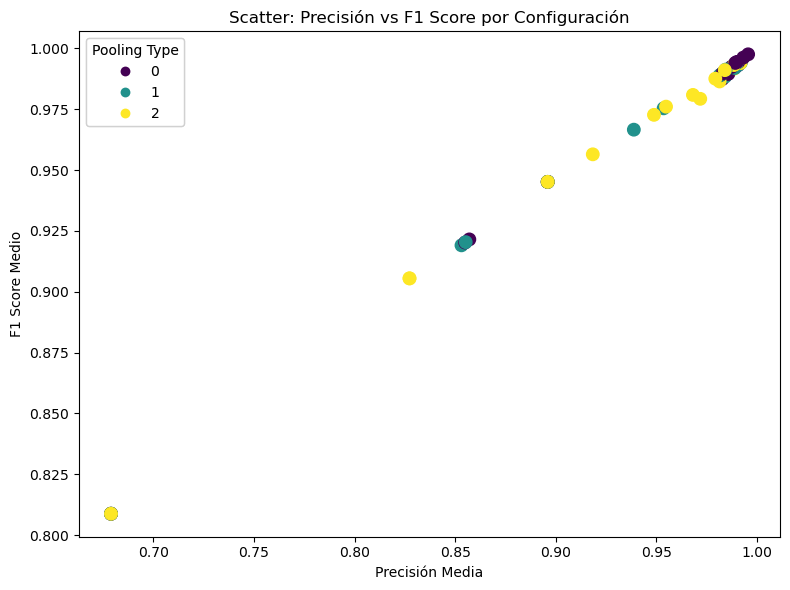

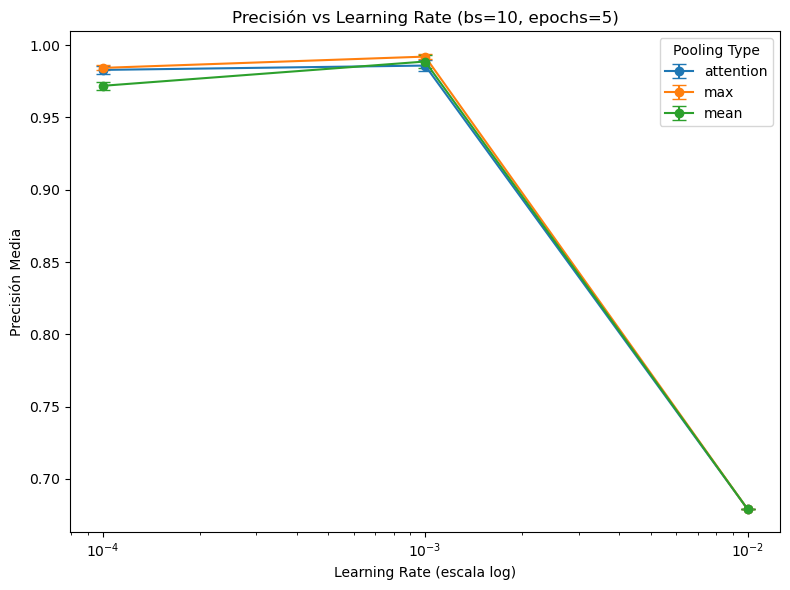

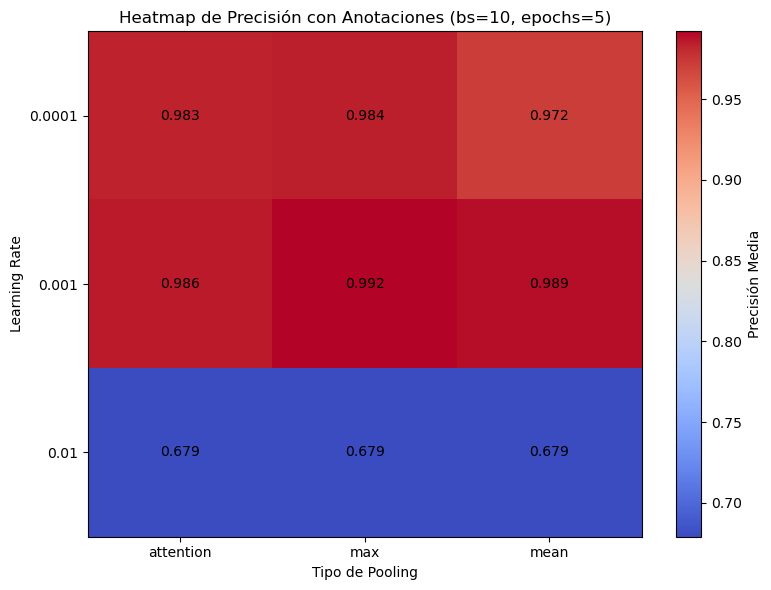

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar datos
df = pd.read_csv("mnist_summary_by_config.csv")

# Filtrar para una configuración fija (ej. bag_size=10, num_epochs=5)
df_fixed = df[(df['bag_size'] == 10) & (df['num_epochs'] == 5)]

# 1) Scatter: Precisión vs F1 Score para todas las configuraciones
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['test_accuracy_mean'], df['test_f1_score_mean'], c=df['pooling_type'].astype('category').cat.codes, s=80, cmap='viridis')
plt.xlabel('Precisión Media')
plt.ylabel('F1 Score Medio')
plt.title('Scatter: Precisión vs F1 Score por Configuración')

# Añadir leyenda
legend1 = plt.legend(*scatter.legend_elements(), title="Pooling Type")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

# 2) Line plot con barras de error: Precisión vs Learning Rate (bs=10, epochs=5)
plt.figure(figsize=(8, 6))
for p in df_fixed['pooling_type'].unique():
    sub = df_fixed[df_fixed['pooling_type'] == p]
    plt.errorbar(sub['learning_rate'], sub['test_accuracy_mean'], yerr=sub['test_accuracy_std'], label=p, marker='o', capsize=5)

plt.xscale('log')
plt.xlabel('Learning Rate (escala log)')
plt.ylabel('Precisión Media')
plt.title('Precisión vs Learning Rate (bs=10, epochs=5)')
plt.legend(title='Pooling Type')
plt.tight_layout()
plt.show()

# 3) Heatmap Mejorado: Precisión Media para cada LR y pooling (bs=10, epochs=5) con valores anotados
lr_vals = sorted(df_fixed['learning_rate'].unique())
pool_vals = sorted(df_fixed['pooling_type'].unique())
mat = np.array([
    [df_fixed[(df_fixed['learning_rate'] == lr) & (df_fixed['pooling_type'] == p)]['test_accuracy_mean'].values[0]
     for p in pool_vals]
    for lr in lr_vals
])

plt.figure(figsize=(8, 6))
heatmap = plt.imshow(mat, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(heatmap, label='Precisión Media')
plt.xticks(range(len(pool_vals)), pool_vals)
plt.yticks(range(len(lr_vals)), lr_vals)
plt.xlabel('Tipo de Pooling')
plt.ylabel('Learning Rate')

# Anotar valores en el heatmap
for i in range(len(lr_vals)):
    for j in range(len(pool_vals)):
        plt.text(j, i, f'{mat[i, j]:.3f}', ha='center', va='center', color='black')

plt.title('Heatmap de Precisión con Anotaciones (bs=10, epochs=5)')
plt.tight_layout()
plt.show()

